# Settings

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from warnings import simplefilter
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from datetime import datetime, timedelta
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error as mse
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import xgboost as xgb
from arch import arch_model
from statsmodels.tsa.seasonal import seasonal_decompose

simplefilter("ignore")

In [20]:
# plotting parameters

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

# Loading the data

In [21]:
df = pd.read_csv(r'energy_prices.csv', squeeze=True)

df = df.rename(columns={'Data':'date', 'RCE':'rce'})

df = df.set_index('date')

df.index = pd.to_datetime(df.index).to_period('D')

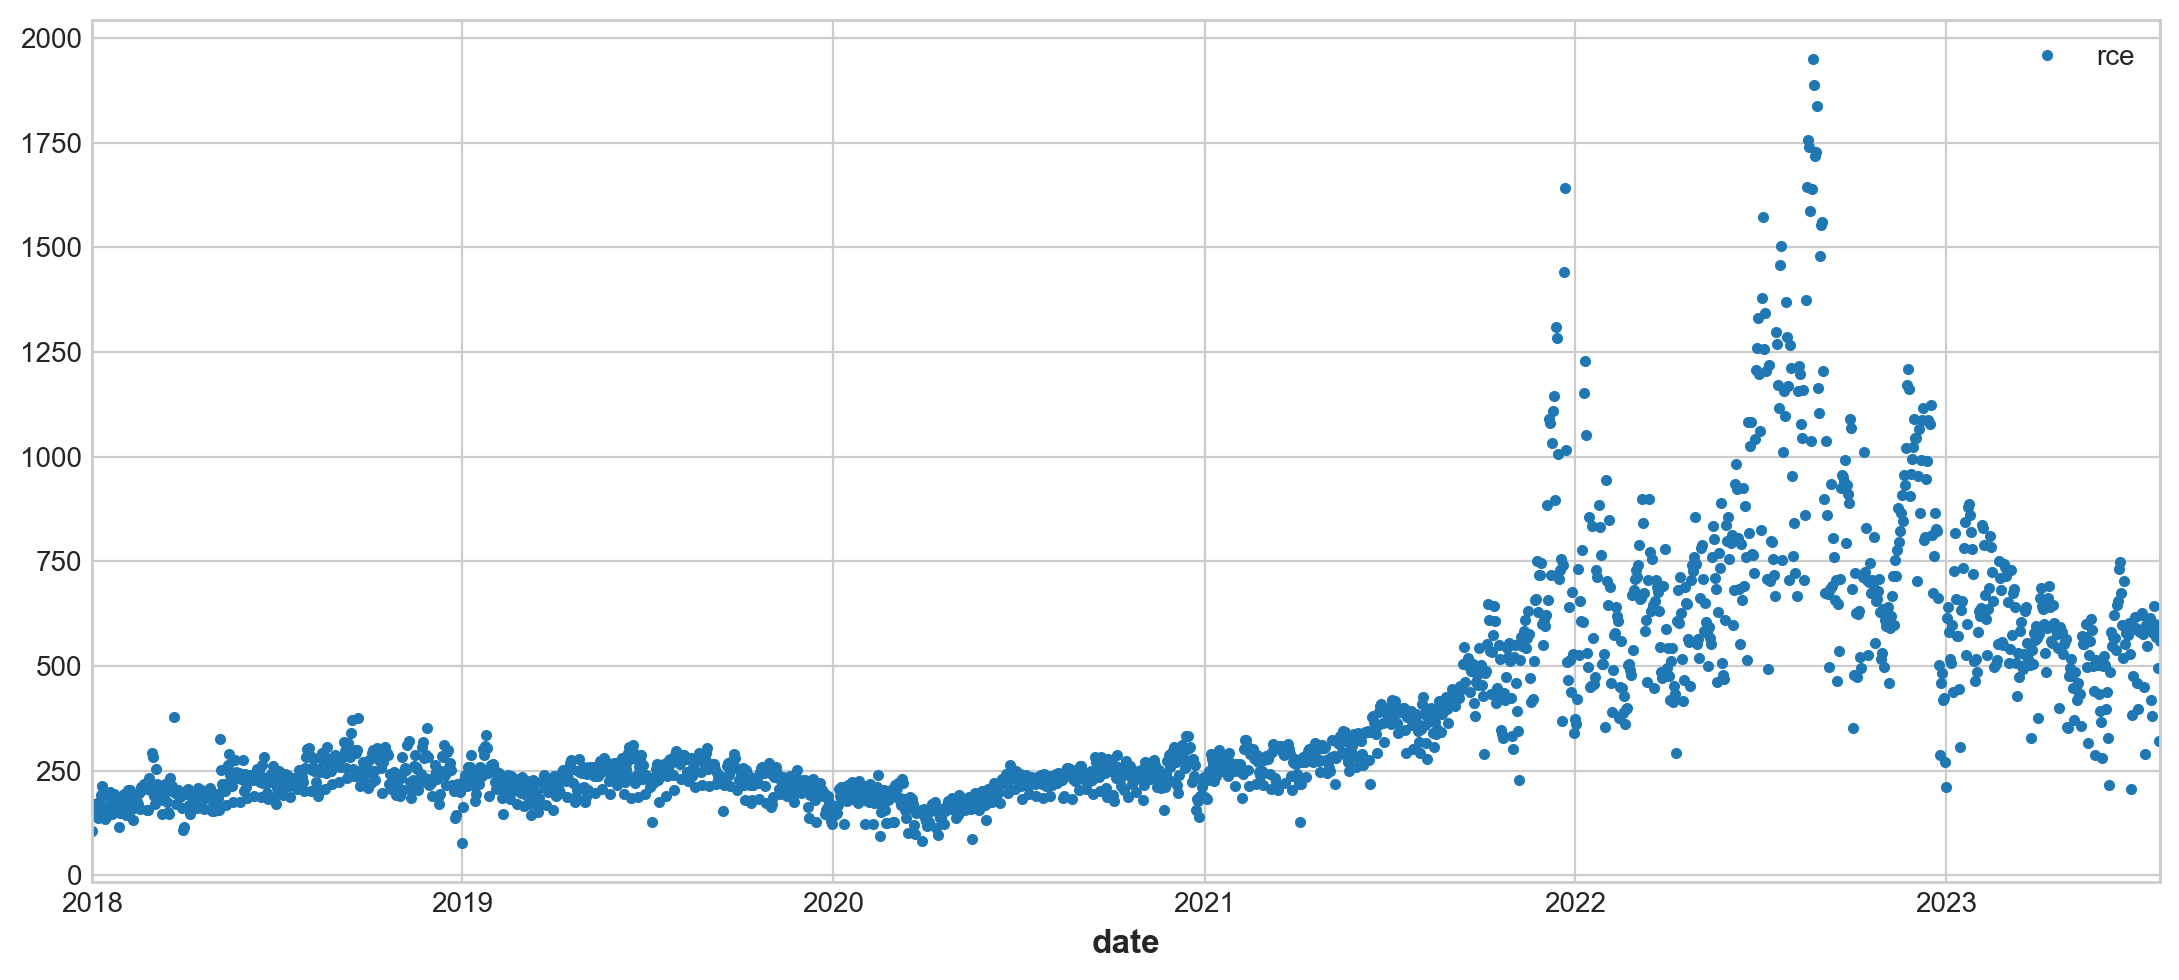

In [22]:
df.plot(style='.');

# Exploratory Data Analysis on the energy prices

### We will take a look at original data, log-transformed data and box-cox-transformed data

Let's check for stationarity with Augmented Dickey-Fuller test.

null hypothesis: time series is non-stationary. It has some time-dependence and it's variance is not constant over time.

alternative hypothesis: time series is stationary.

In [23]:
def check_for_stationarity(df):
    adf = adfuller(df)
    p_value = adf[1]

    if p_value >= 0.05:
        print(f'P-value = {p_value:.2f}.\nWe fail to reject the null hypothesis. Data is non-stationary.')
    else:
        print(f'P-value = {p_value:.2f}.\nData is stationary')

check_for_stationarity(df['rce'])

P-value = 0.29.
We fail to reject the null hypothesis. Data is non-stationary.


In [24]:
bdf = df.copy()
transformed_rce, _ = stats.boxcox(bdf['rce'])
bdf['rce'] = transformed_rce

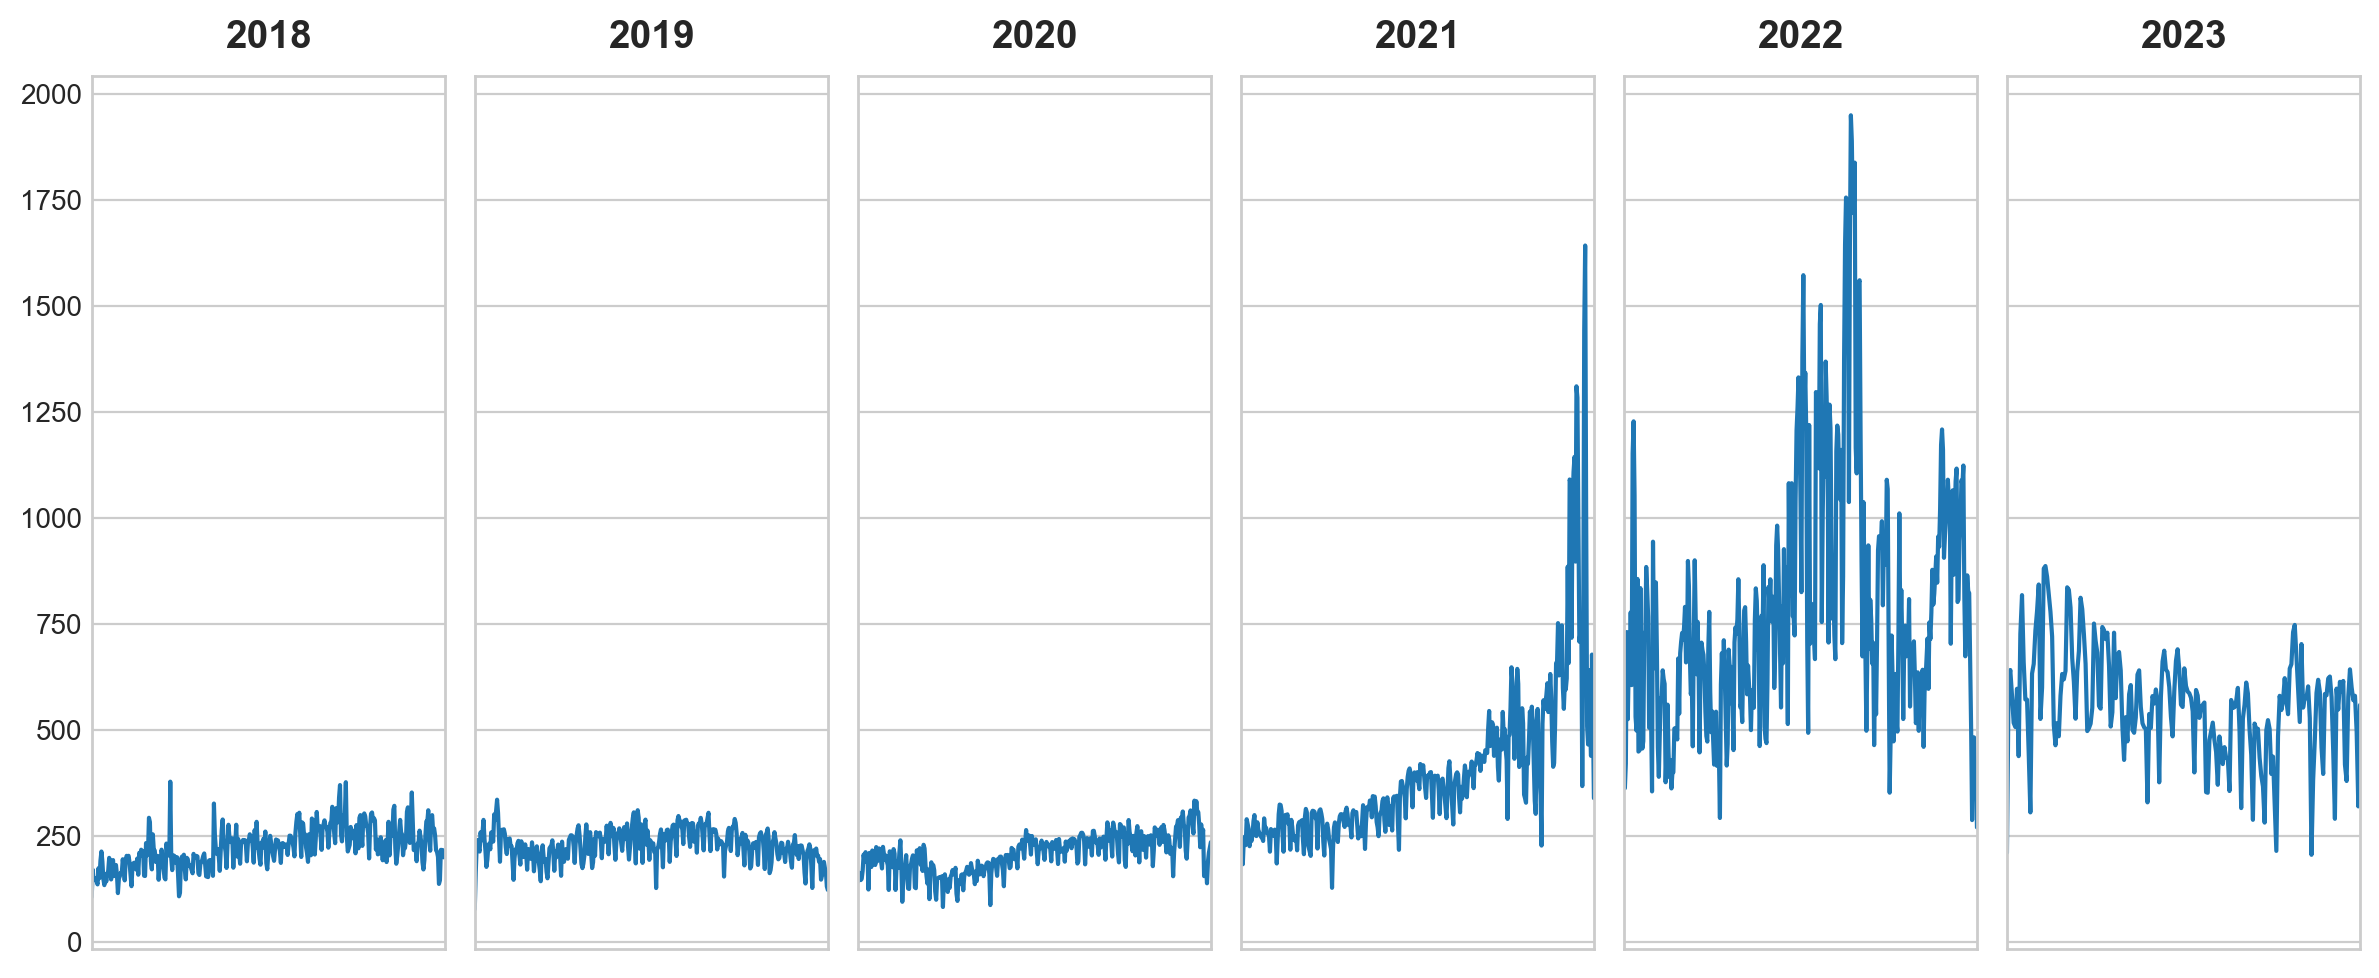

In [25]:
groups = df.groupby(pd.Grouper(freq='A'))
fig, axes = plt.subplots(figsize=(12, 5), ncols=len(groups), sharey=True)

for i, (year, group) in enumerate(groups):
    ax = axes[i]
    group.plot(ax=ax, legend=False)
    ax.set_title(year.year) 
    ax.get_xaxis().set_visible(False)
    
plt.tight_layout()

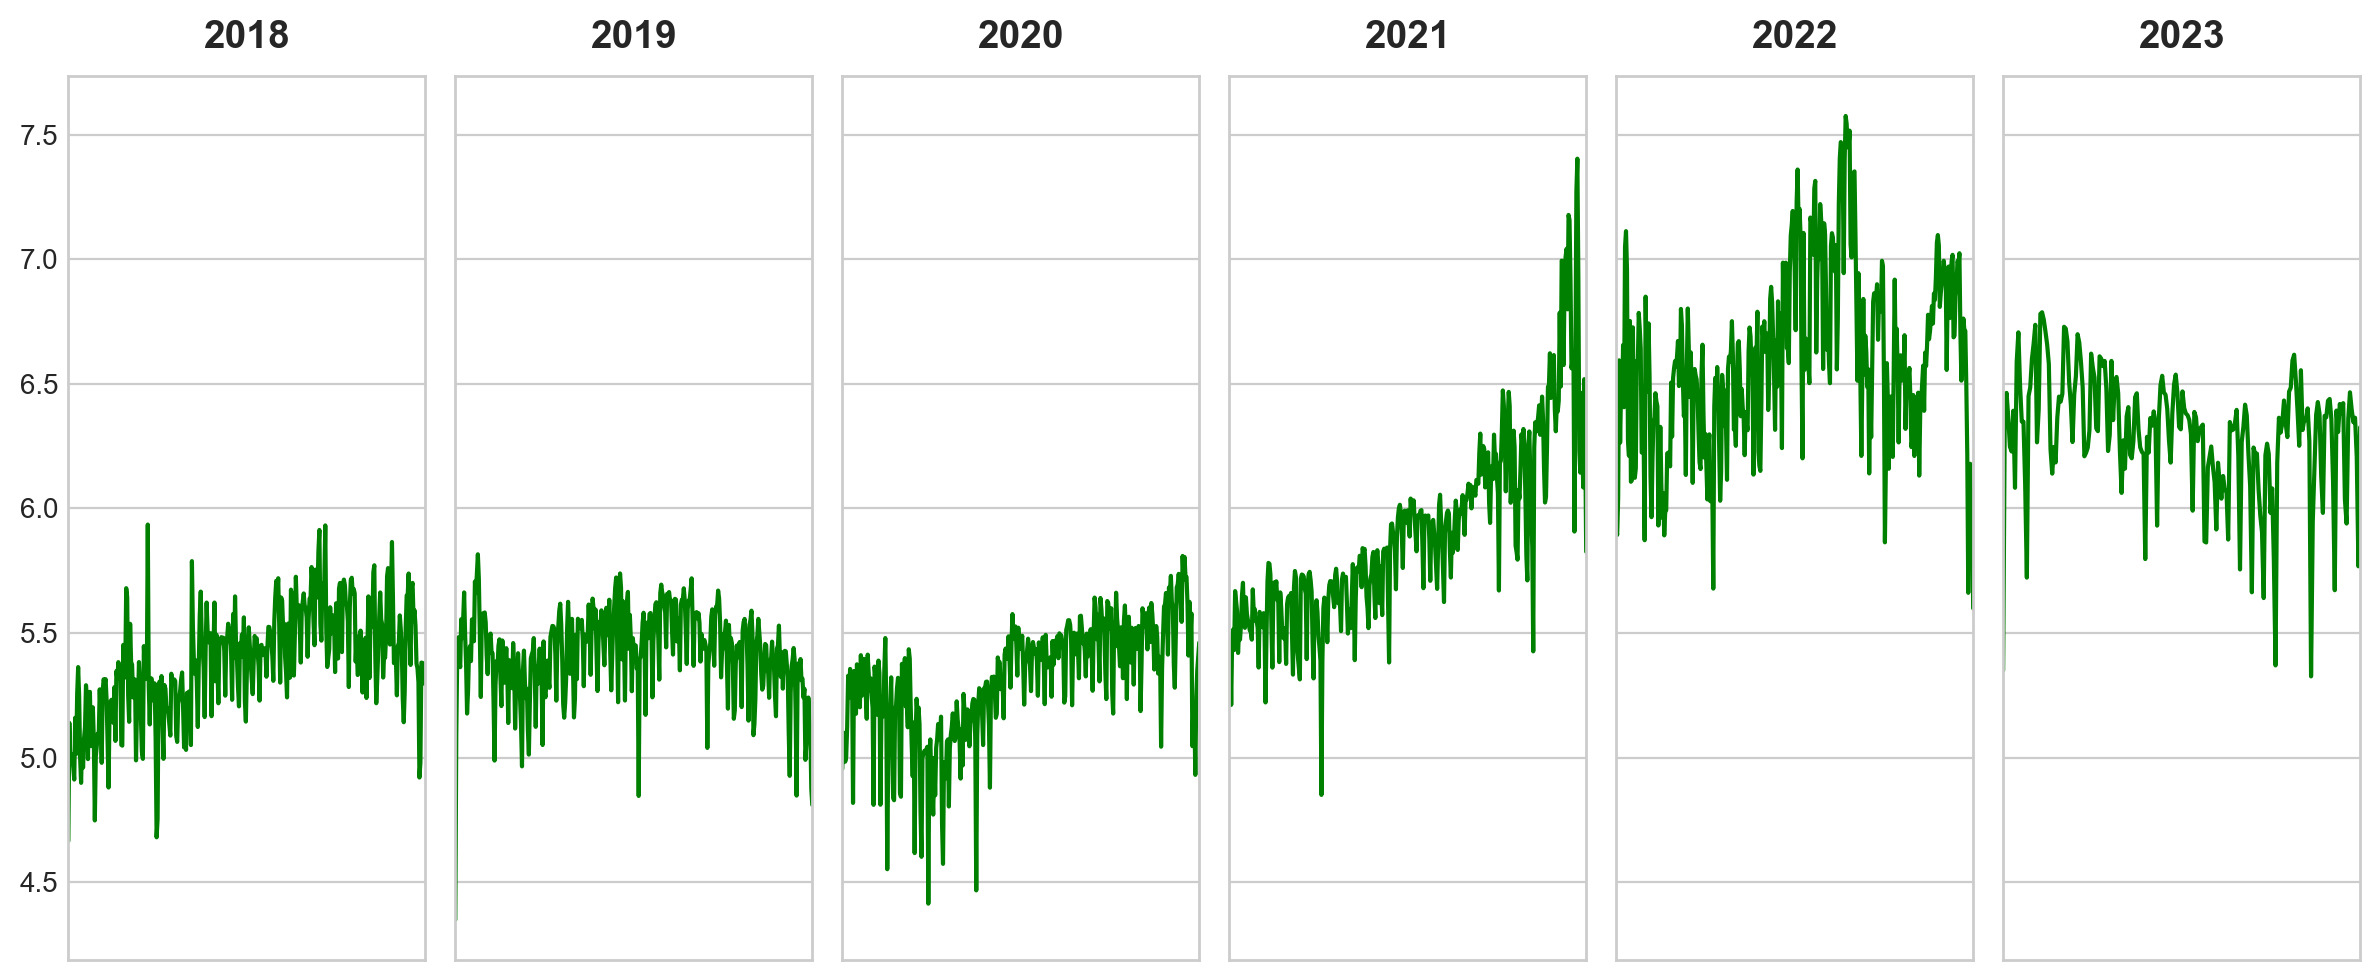

In [26]:
log_groups = np.log(df).groupby(pd.Grouper(freq='A'))
fig, axes = plt.subplots(figsize=(12, 5), ncols=len(groups), sharey=True)

for i, (year, group) in enumerate(log_groups):
    ax = axes[i]
    group.plot(ax=ax, legend=False, color='g')
    ax.set_title(year.year) 
    ax.get_xaxis().set_visible(False)

plt.tight_layout()

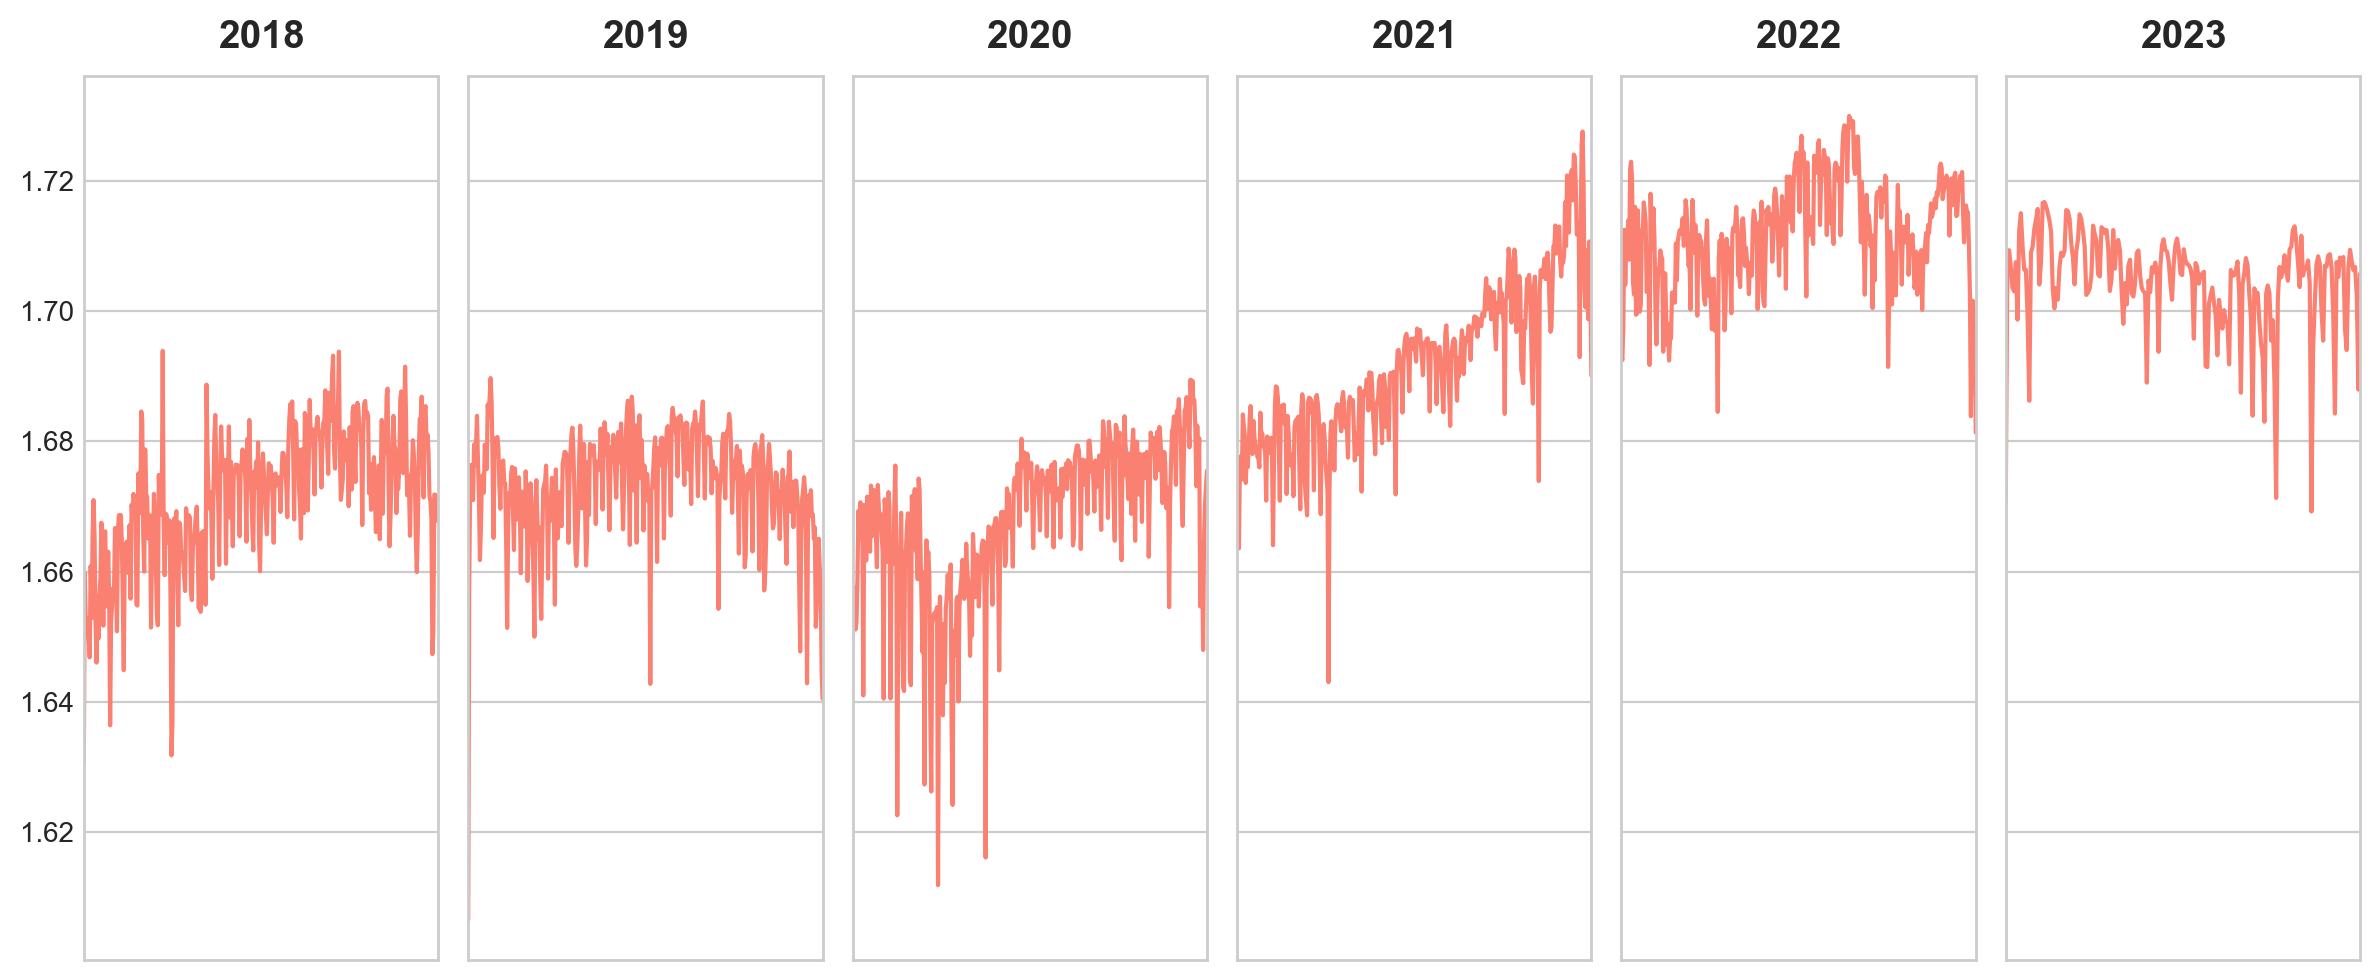

In [27]:
boxcox_groups = bdf.groupby(pd.Grouper(freq='A'))
fig, axes = plt.subplots(figsize=(12, 5), ncols=len(groups), sharey=True)

for i, (year, group) in enumerate(boxcox_groups):
    ax = axes[i]
    group.plot(ax=ax, legend=False, color='salmon')
    ax.set_title(year.year) 
    ax.get_xaxis().set_visible(False)

plt.tight_layout()

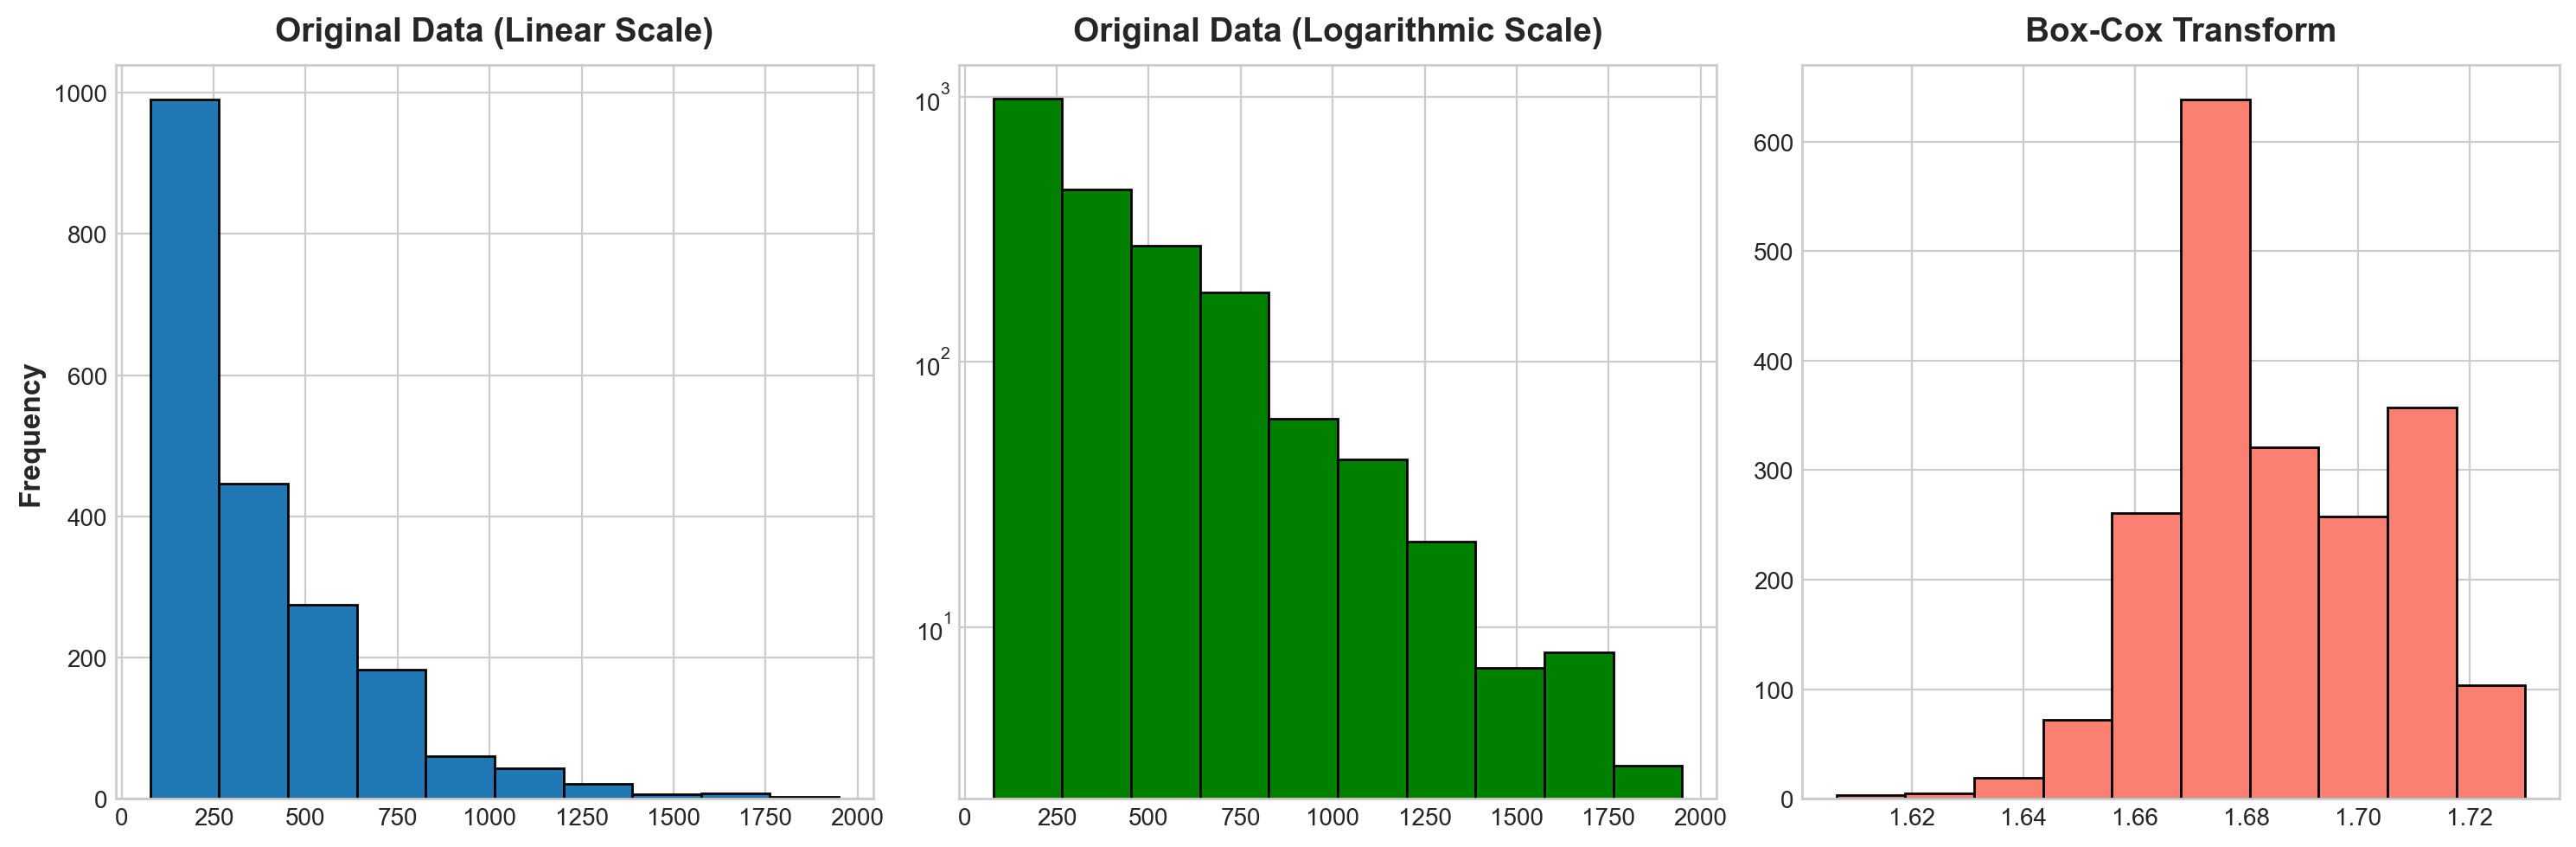

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(df['rce'], bins=10, edgecolor='black')
axes[0].set_title('Original Data (Linear Scale)')
axes[0].set_ylabel('Frequency')

axes[1].hist(df['rce'], bins=10, log=True, color='g', edgecolor='black')
axes[1].set_title('Original Data (Logarithmic Scale)')

axes[2].hist(bdf['rce'], bins=10, color='salmon', edgecolor='black')
axes[2].set_title('Box-Cox Transform');

In [29]:
print('\t\tOriginal Data\t\tLog Data\t\tBox-Cox Data')
print(f'Skewness: \t{df.rce.skew():.2f} \t\t\t{np.log(df).rce.skew():.2f} \t\t\t{bdf.rce.skew():.2f}')
print(f'Kurtosis: \t{df.rce.kurt():.2f} \t\t\t{np.log(df).rce.kurt():.2f} \t\t\t{bdf.rce.kurt():.2f}')

		Original Data		Log Data		Box-Cox Data
Skewness: 	1.97 			0.68 			0.08
Kurtosis: 	4.75 			-0.31 			-0.47


Original distribution looks like Power Law distribution.
A positive value for the kurtosis indicates a distribution more peaked than normal, in this case it's very peaked.
Log transform and Box-Cox transform seem to fix the excessive peak.
If Kurtosis is higher than 1, data is extremely skewed. 

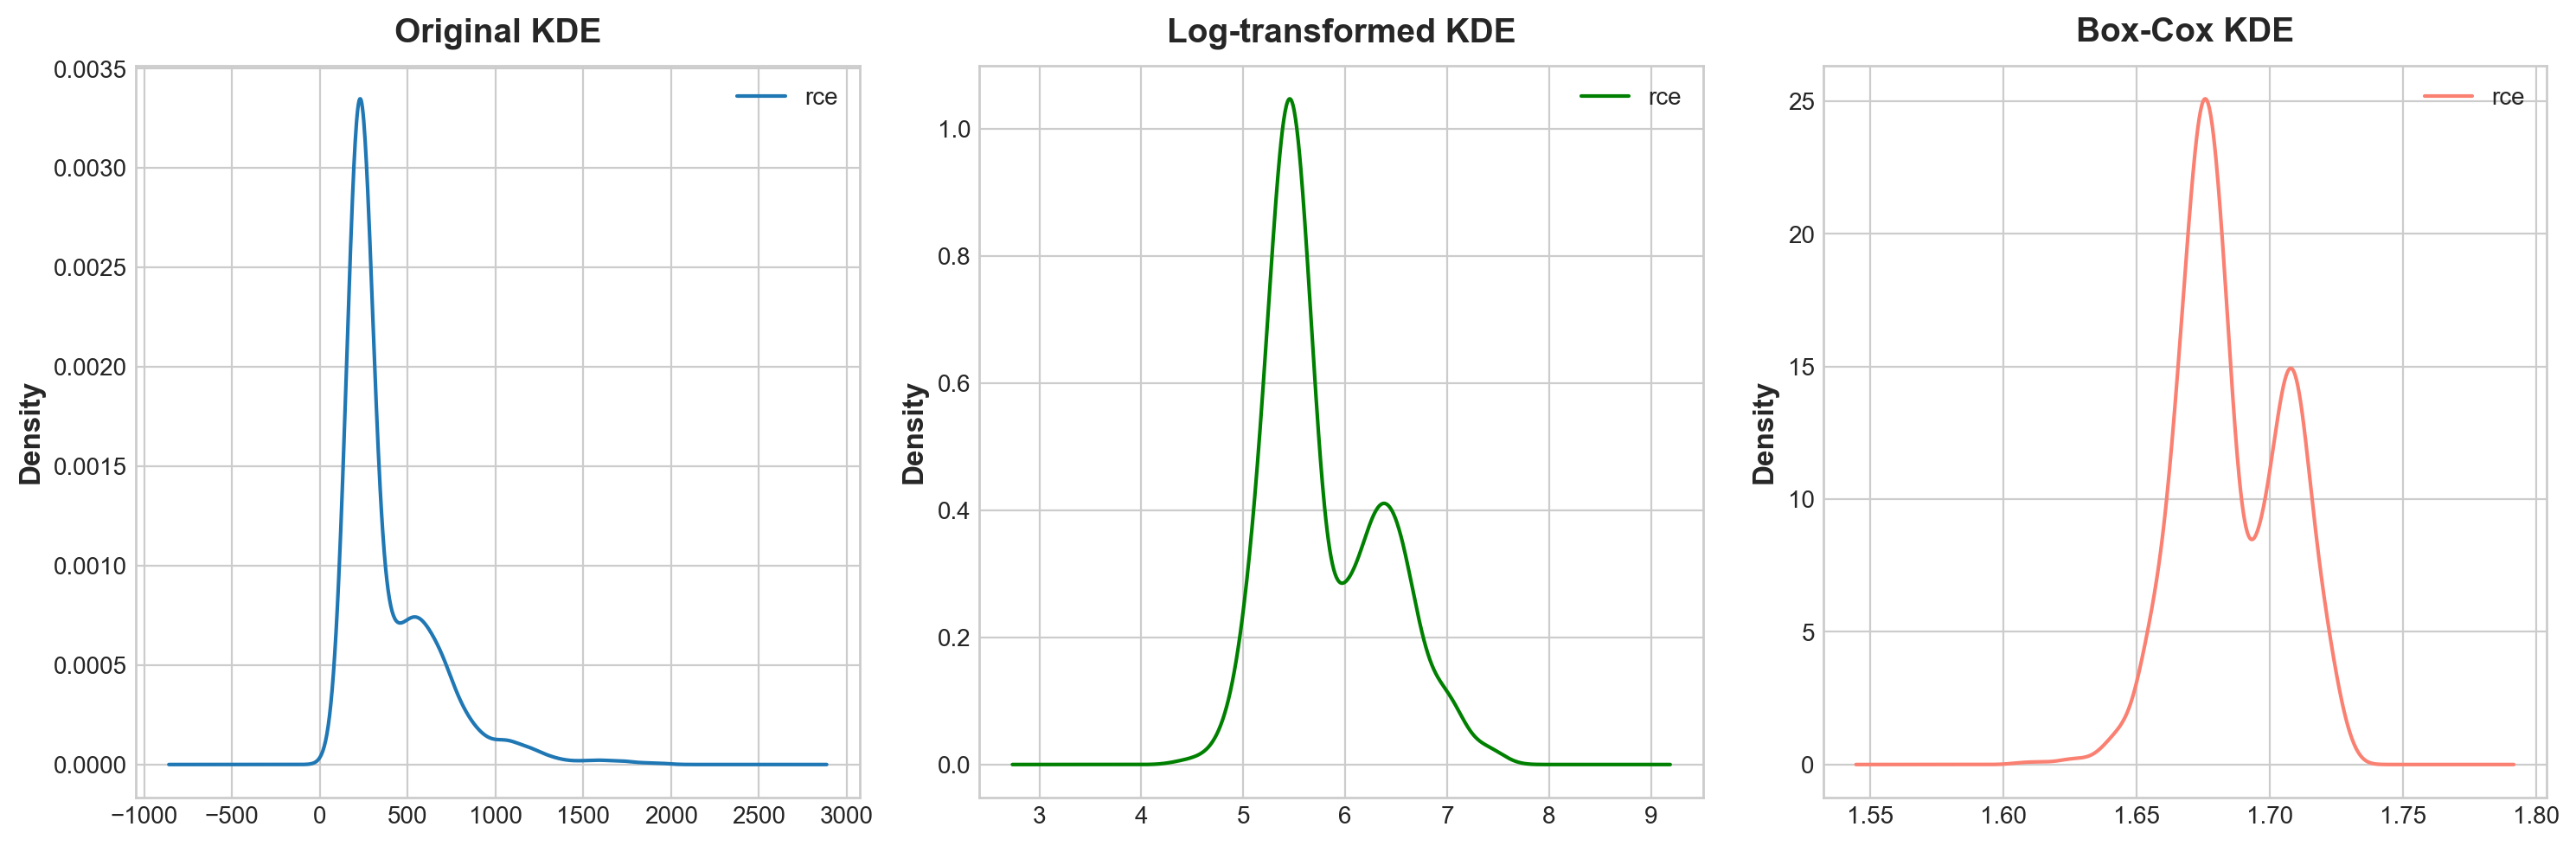

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

np.log(df).plot.kde(ax=axes[1], c='g')
axes[1].set_title('Log-transformed KDE')

df.plot.kde(ax=axes[0])
axes[0].set_title('Original KDE')

bdf.plot.kde(ax=axes[2], color='salmon')
axes[2].set_title('Box-Cox KDE')

plt.tight_layout()

Does kernel density estimator tell us something important? It seems like data would be Gaussian, if it was not for the past June 2021 events. 

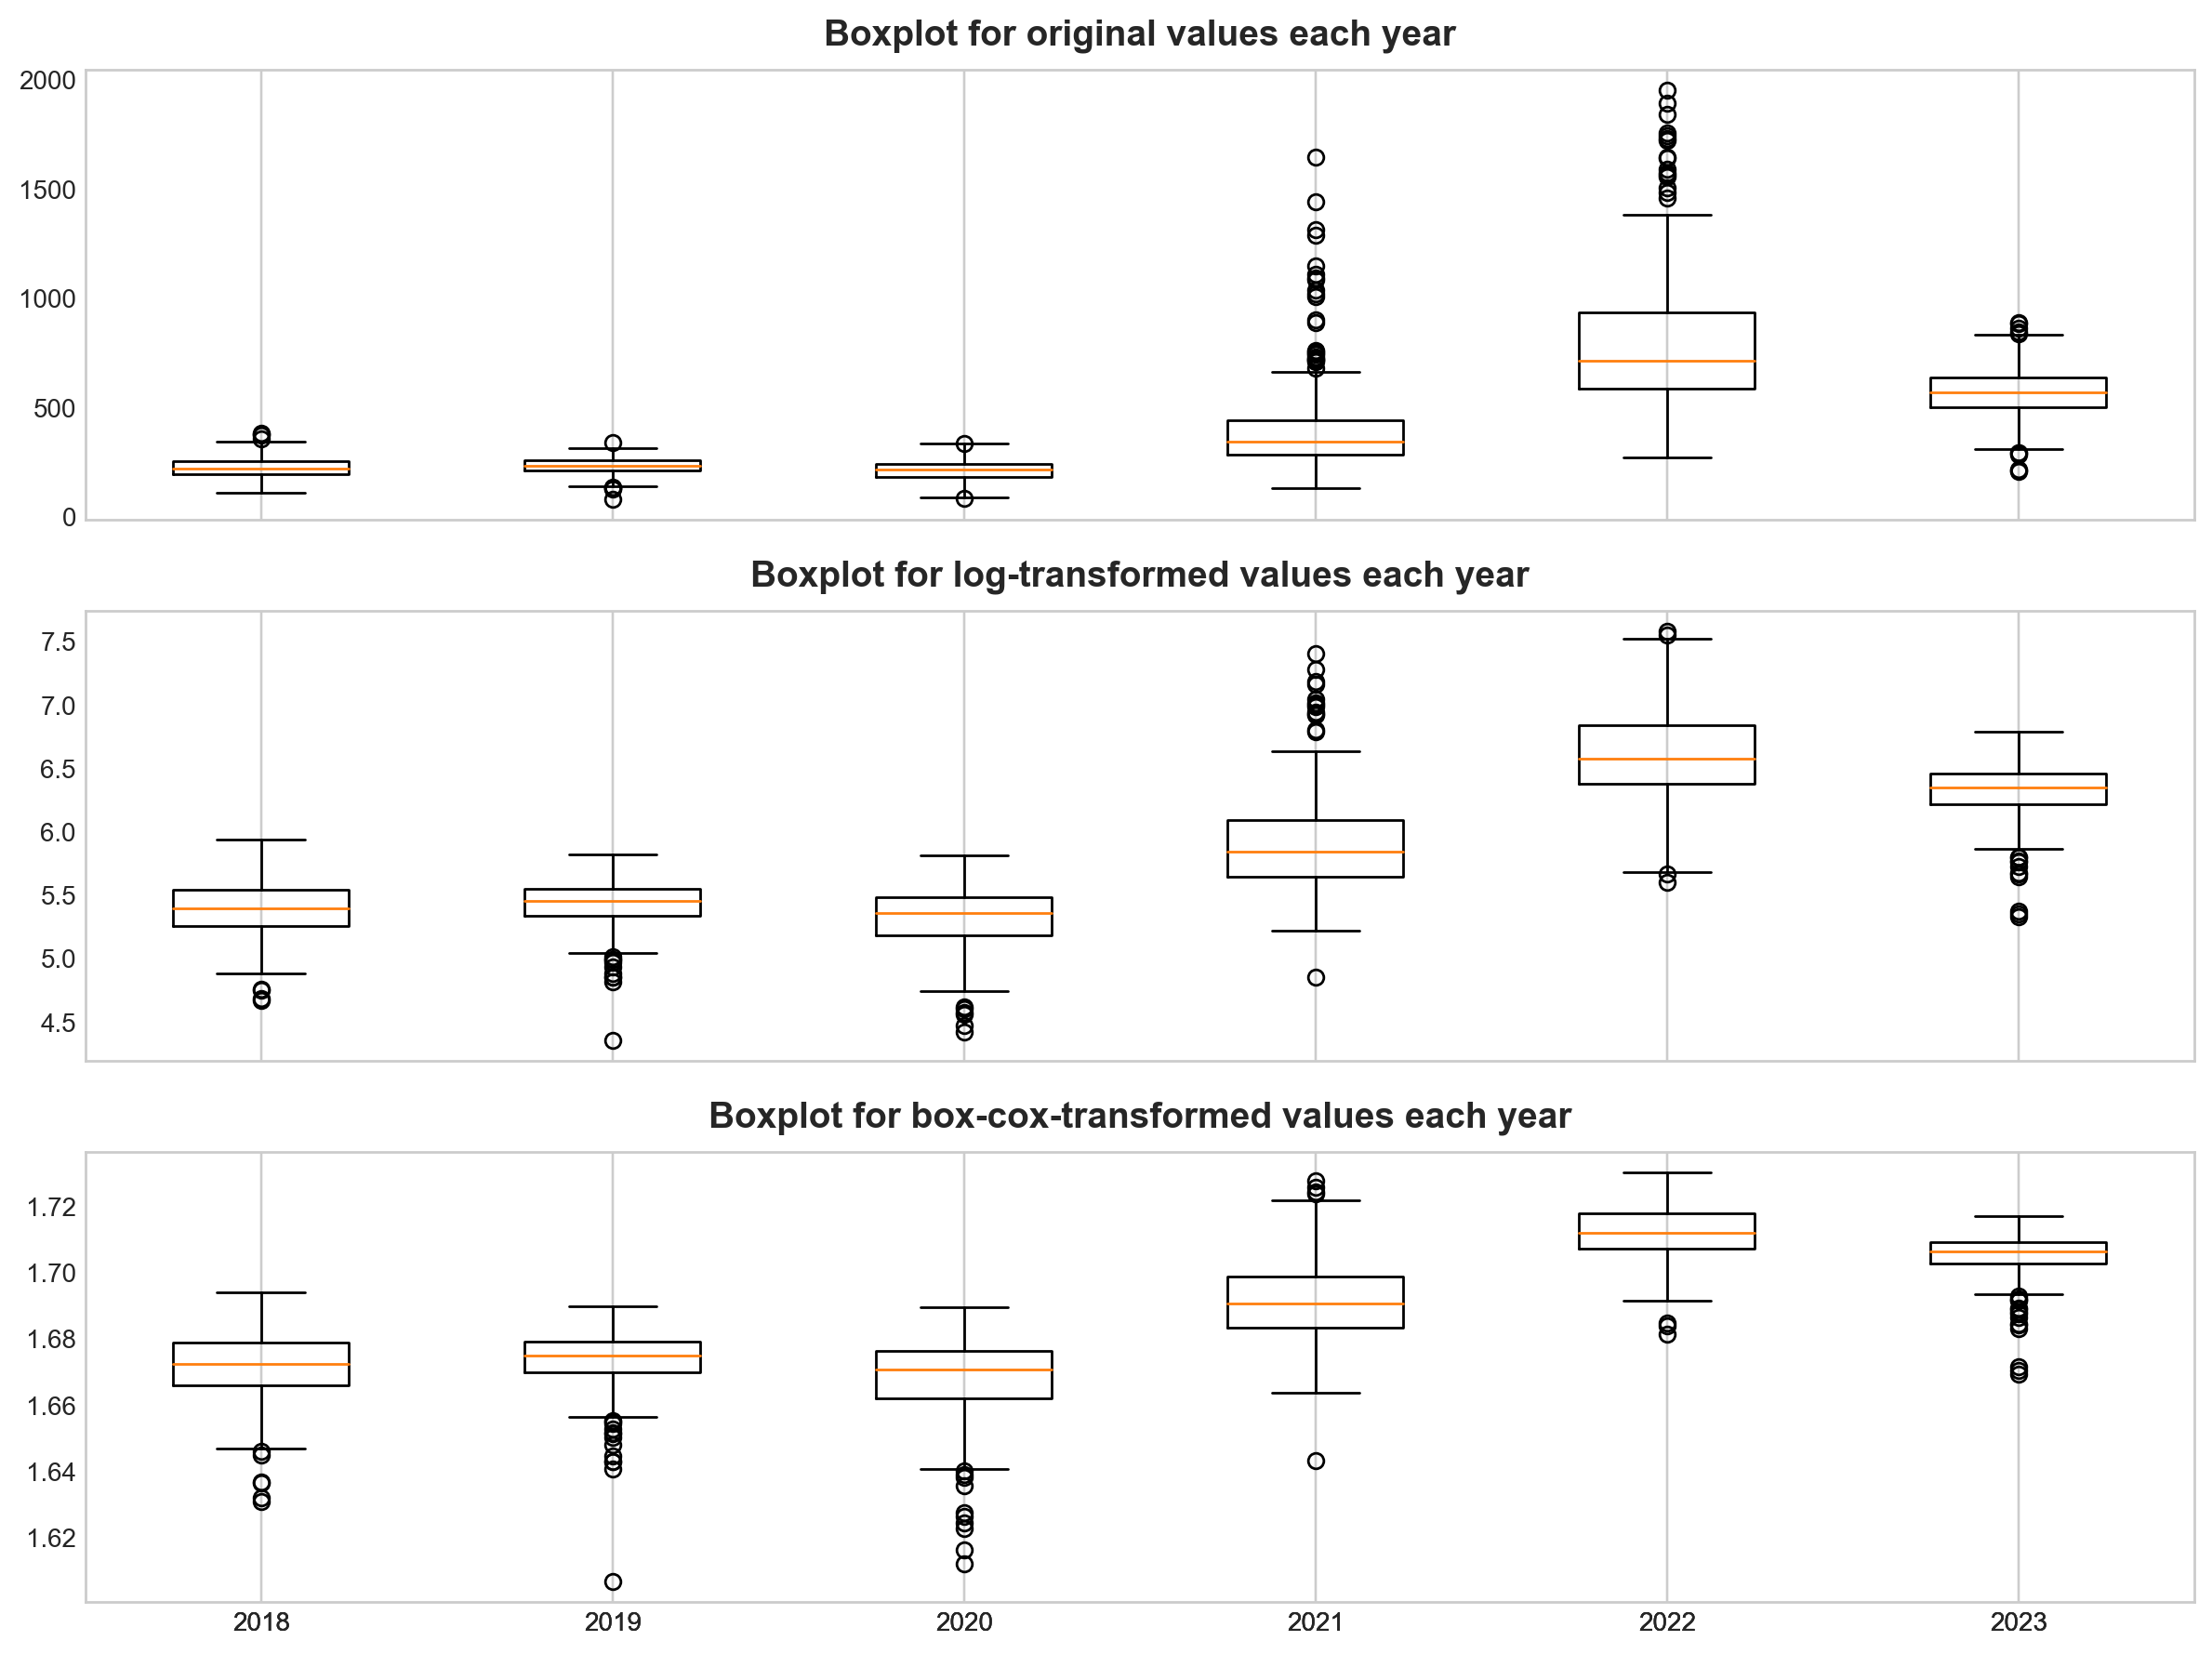

In [31]:
fig, axes = plt.subplots(3, 1, figsize=(12,9), sharex=True)

axes[0].boxplot([df[df.index.year == year]['rce'] for year in range(2018, 2024)], labels=[str(year) for year in range(2018, 2024)])
axes[0].set_title('Boxplot for original values each year') 
axes[1].boxplot([np.log(df)[df.index.year == year]['rce'] for year in range(2018, 2024)], labels=[str(year) for year in range(2018, 2024)])
axes[1].set_title('Boxplot for log-transformed values each year')
axes[2].boxplot([bdf[bdf.index.year == year]['rce'] for year in range(2018, 2024)], labels=[str(year) for year in range(2018, 2024)])
axes[2].set_title('Boxplot for box-cox-transformed values each year') 

axes[0].grid(axis='y')
axes[1].grid(axis='y')
axes[2].grid(axis='y')

We can easily spot many outliers in the last 3 years of observations.
Also, we see that log-transform does pretty good job for the 2021-2022 outliers, with a small cost for previous years.
However, Box-Cox transform fixes the 2021-2022 outliers with a higher cost for previous years than log transform.

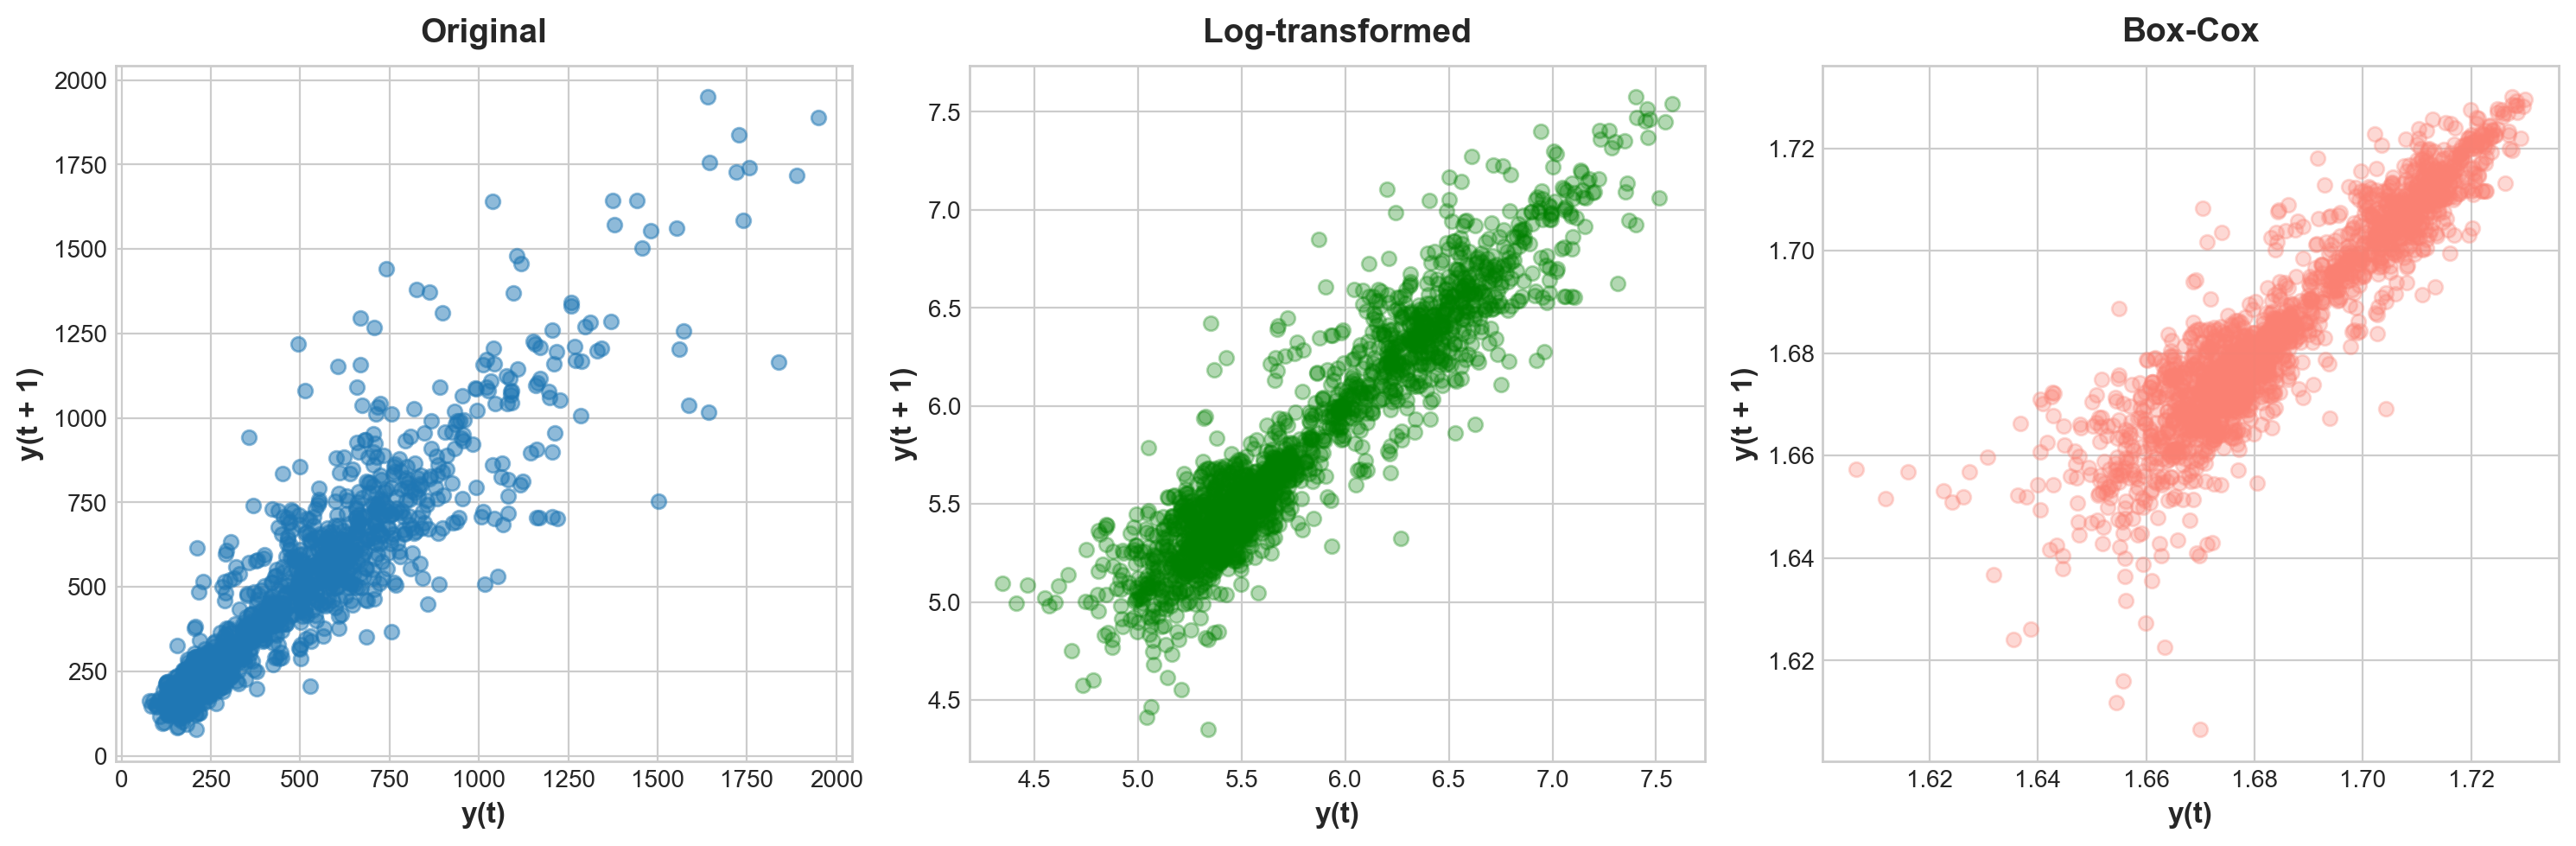

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

pd.plotting.lag_plot(np.log(df), ax=axes[1], c='g', alpha=0.3)
axes[1].set_title('Log-transformed')

pd.plotting.lag_plot(df, ax=axes[0], alpha=0.5)
axes[0].set_title('Original')

pd.plotting.lag_plot(bdf, ax=axes[2], c='salmon', alpha=0.3)
axes[2].set_title('Box-Cox')

plt.tight_layout()

We can see the data is not random, and that it follows some kind of a trend, especially the data up to June 2021. It used to be dependent on previous day value. On top of that, log-transformed data seems to handle itself better.

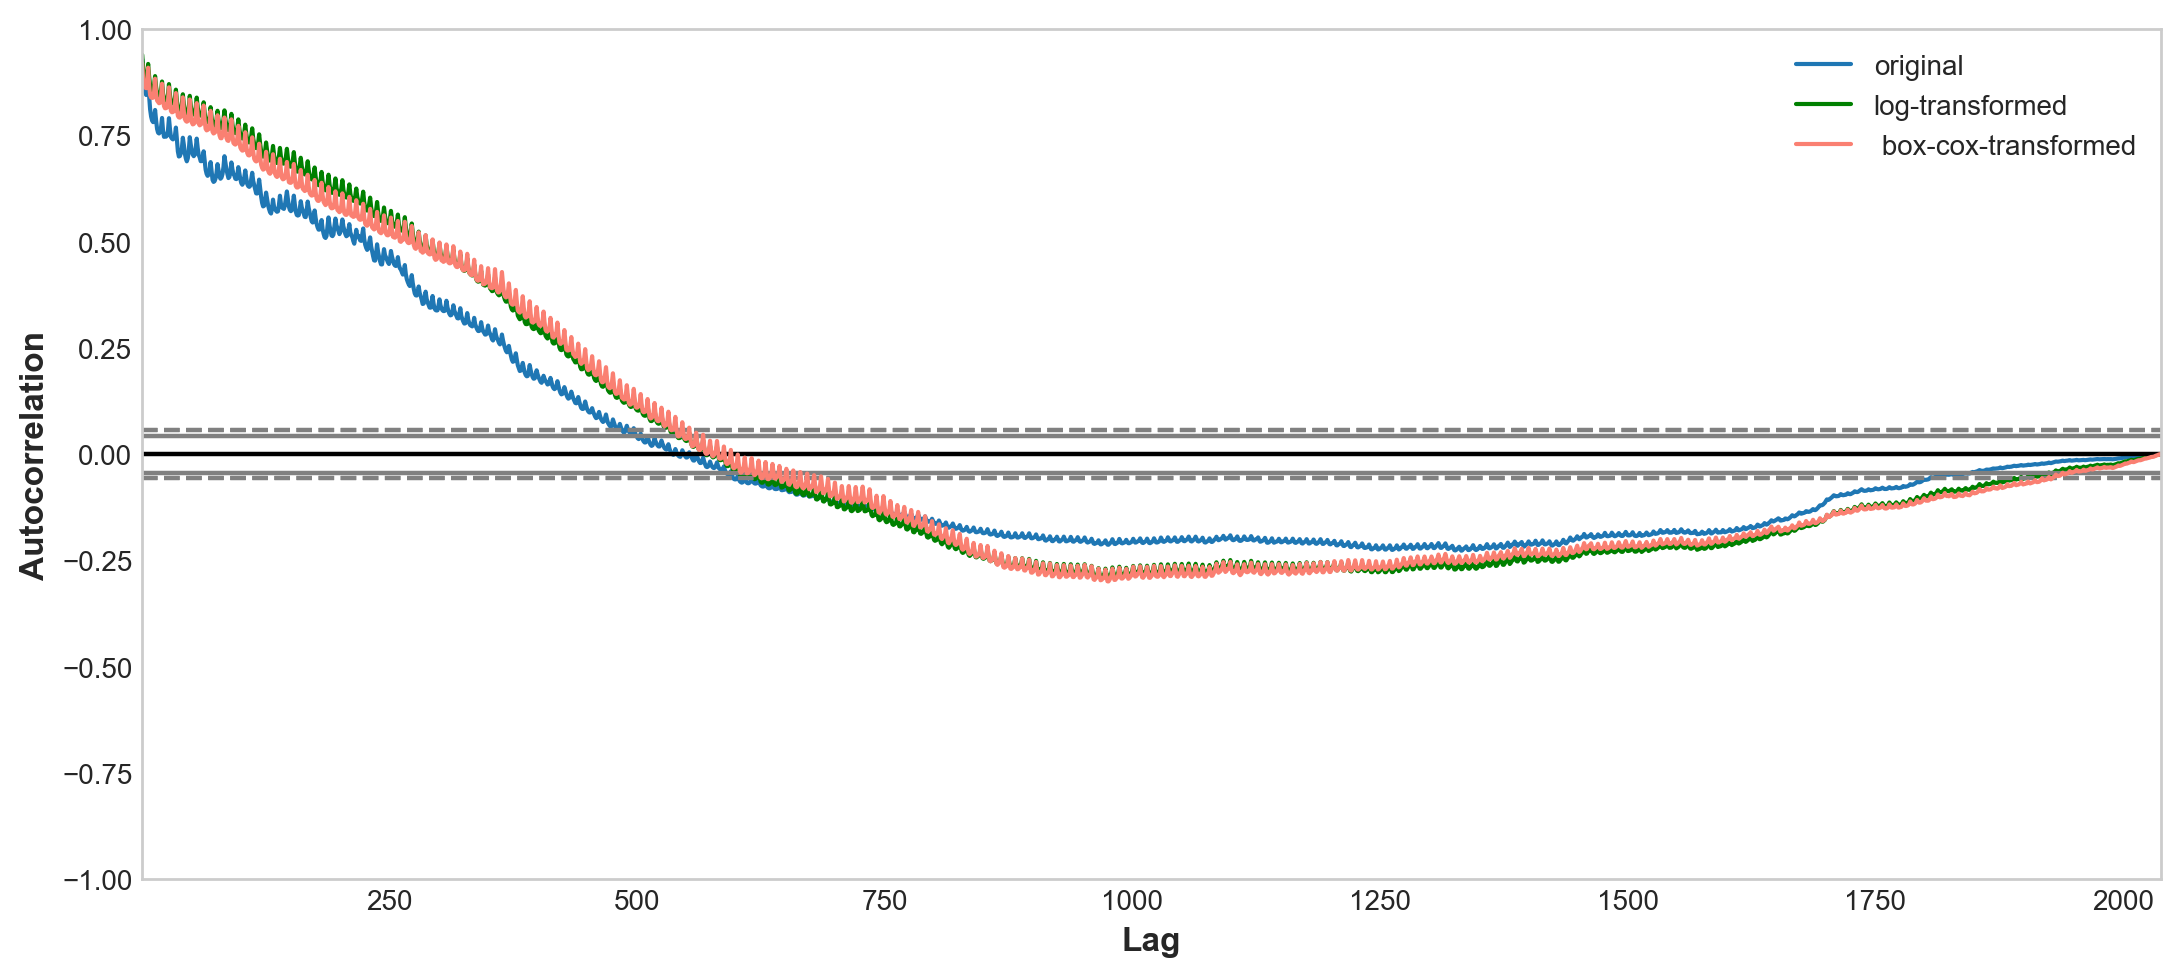

In [33]:
pd.plotting.autocorrelation_plot(df, label = 'original')
pd.plotting.autocorrelation_plot(np.log(df), label = 'log-transformed', color='g')
pd.plotting.autocorrelation_plot(bdf, label= ' box-cox-transformed', color='salmon')
plt.tight_layout();
plt.legend();

If autocorrelation values are close to 0, then values between consecutive observations are not correlated with one another. Inversely, autocorrelations values close to 1 or -1 indicate that there exists strong positive or negative correlations between consecutive observations, respectively.
We can assume, that there is no autocorrelation based on Ljung-Box test statistics, and the ACF Plot.

If the ACF was decaying, we would be likely dealing with an auto regressive process.

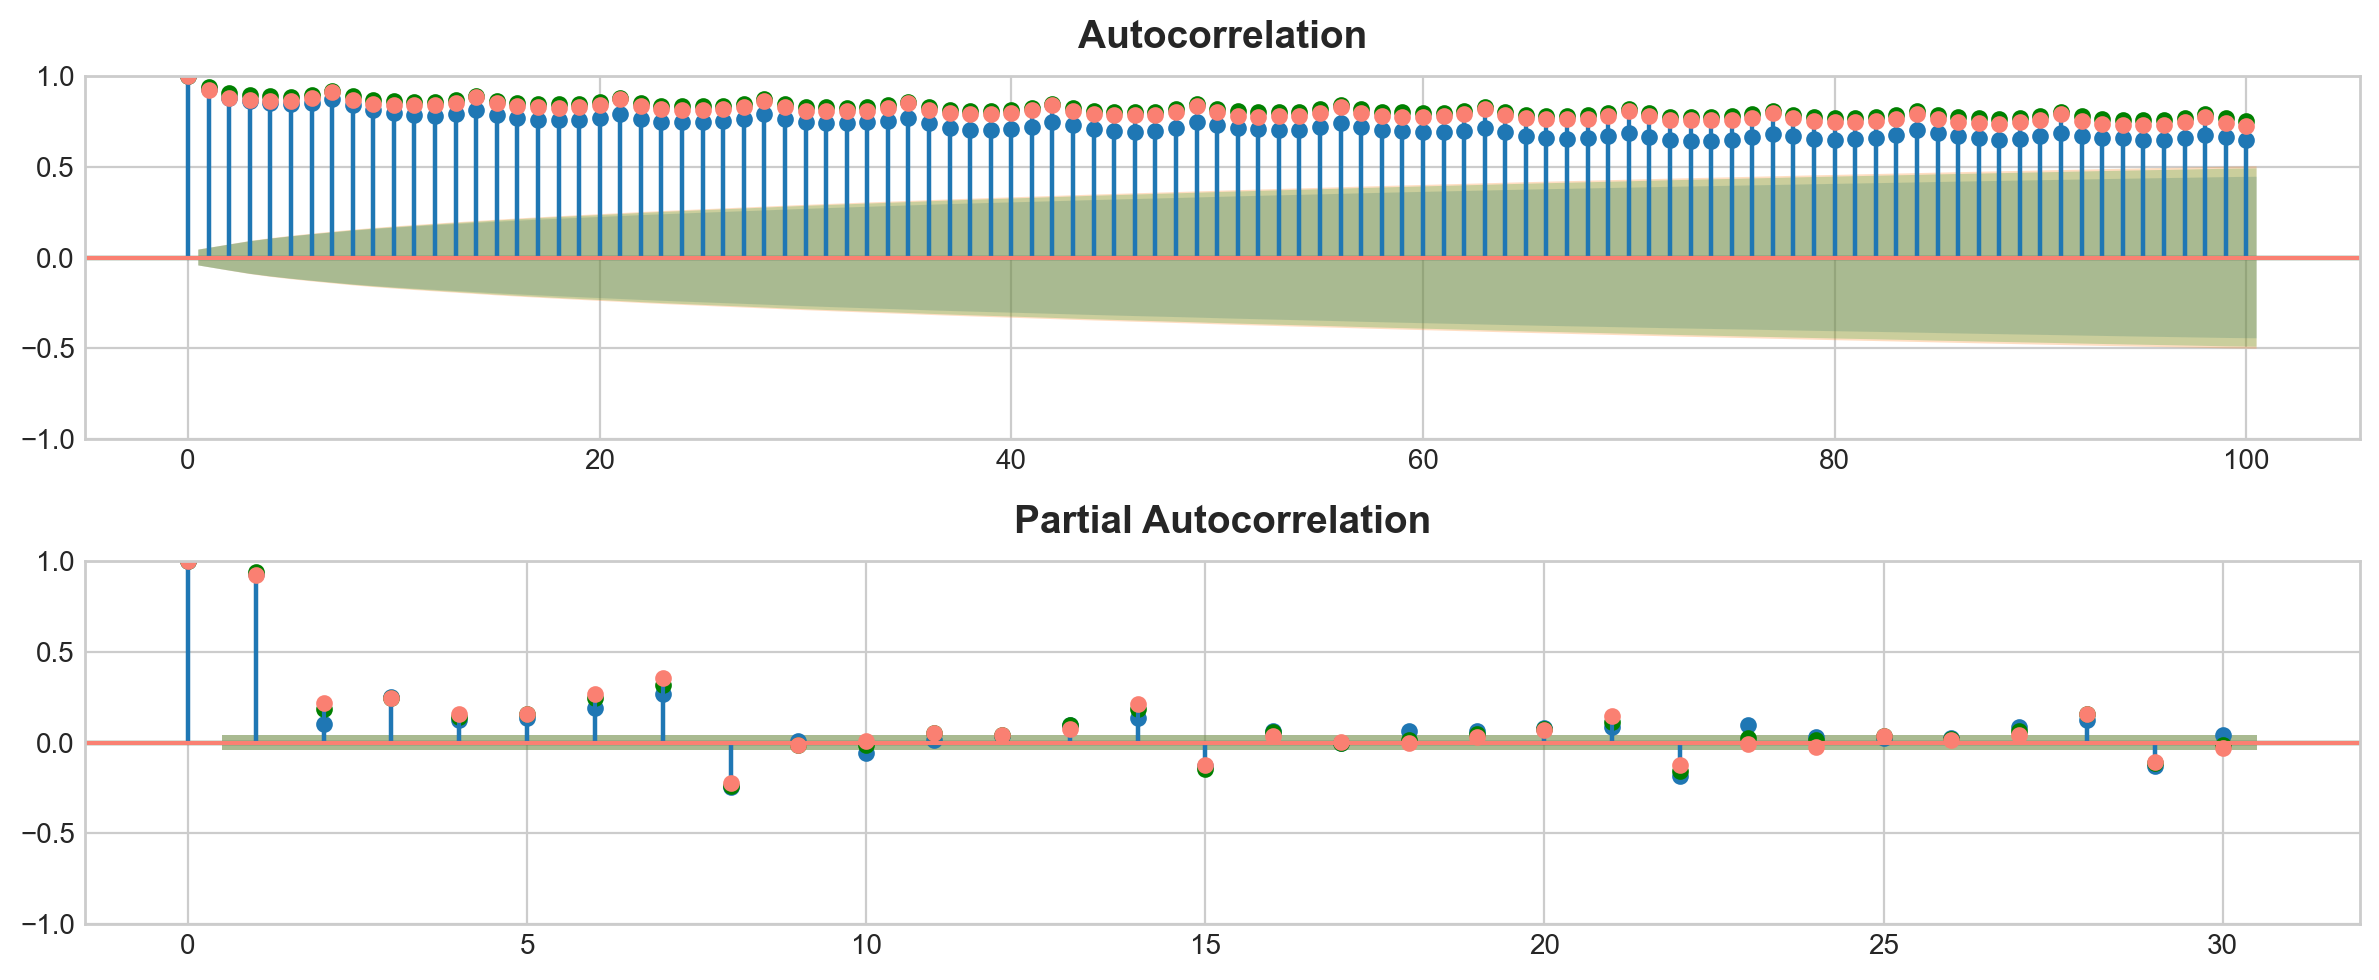

In [34]:
fig, axes = plt.subplots(2,1, figsize=(12,5))
plot_acf(df, lags=100, ax=axes[0], label='original');
plot_acf(np.log(df), lags=100, ax=axes[0], c='green', label='log transformed');
plot_acf(bdf, lags=100, ax=axes[0], c='salmon');

plot_pacf(df, lags=30, ax=axes[1], label='original');
plot_pacf(np.log(df), lags=30, ax=axes[1], c='green', label='log transformed');
plot_pacf(bdf, lags=30, ax=axes[1], c='salmon', label='box-cox');

Based on PACF, we should start with an Auto Regressive model on lag 1, 3, 7, 8, maybe 23.
It does not give us much information however, the data is not stationary.

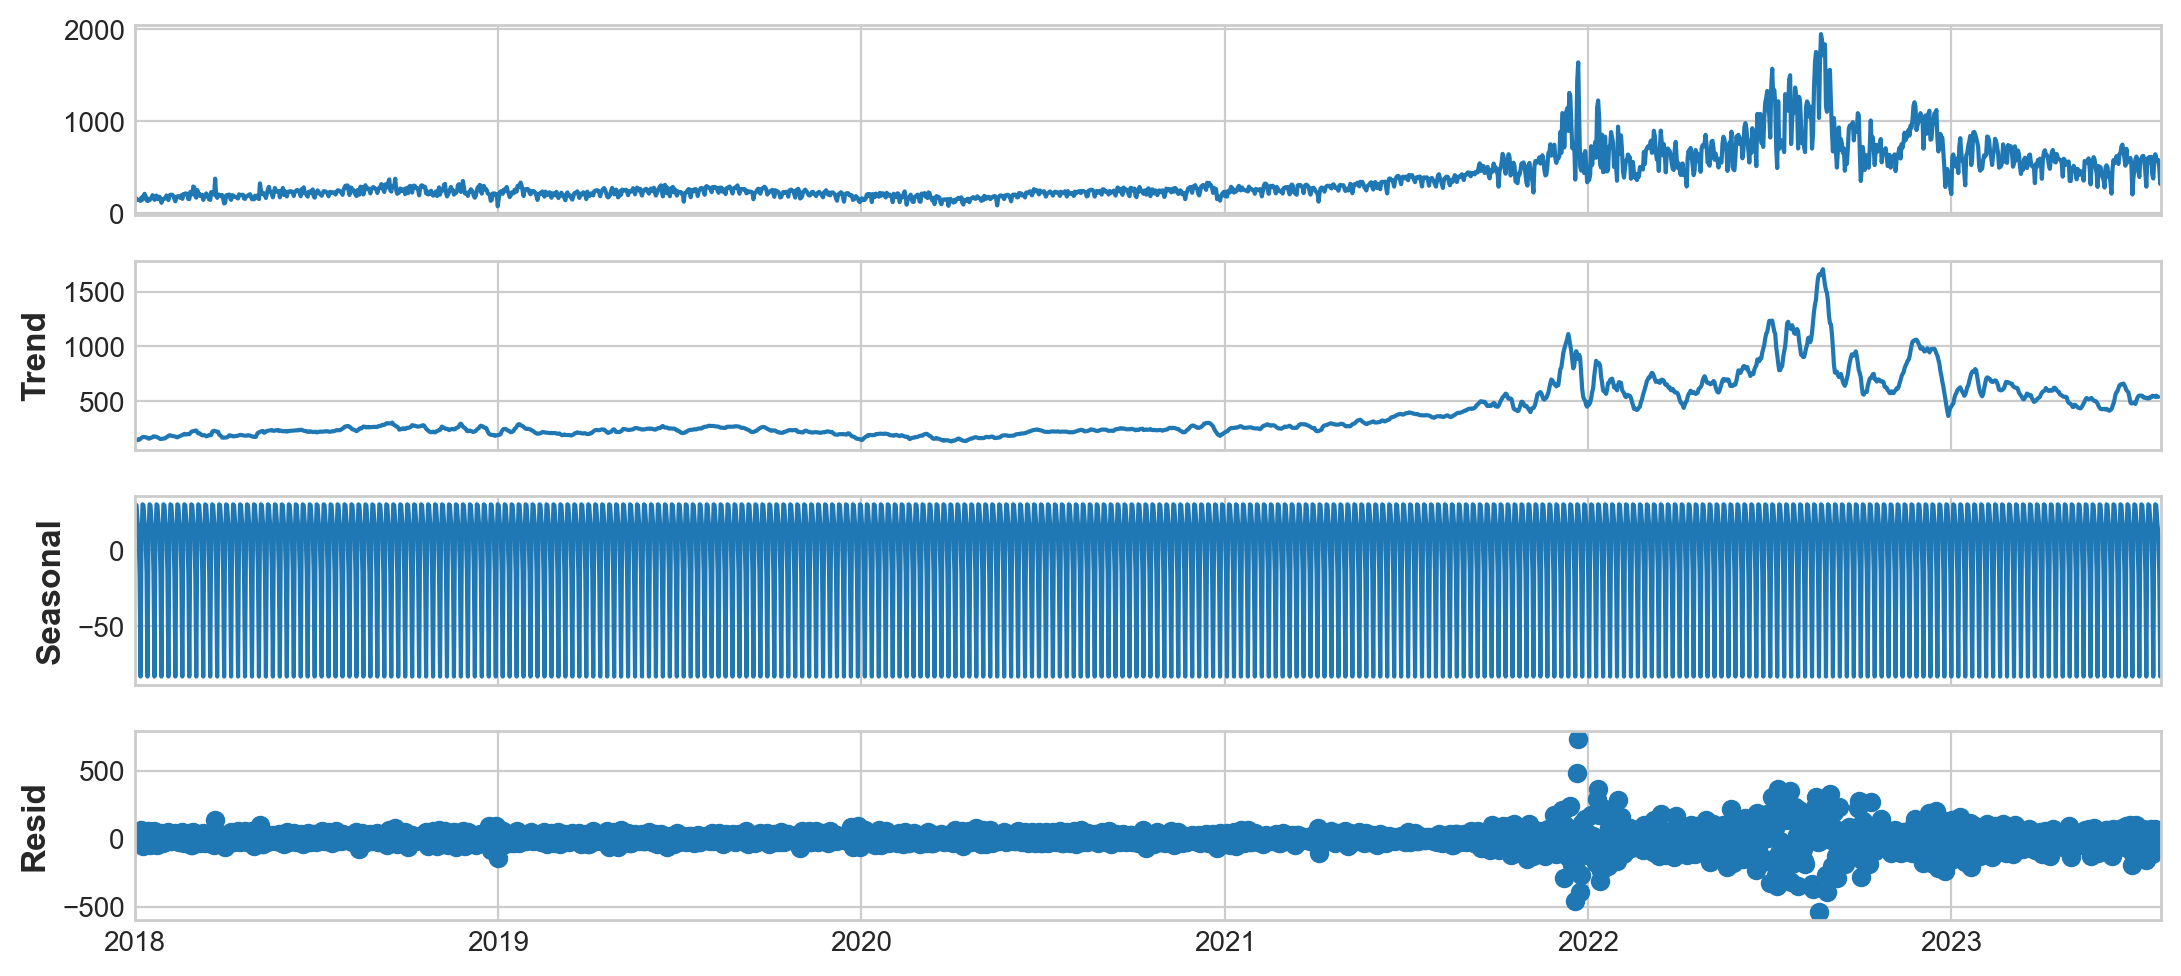

In [35]:
df.index = df.index.astype('datetime64[ns]')
decomp = seasonal_decompose(df)
decomp.plot();

In [36]:
df = df.copy()
df = np.log(df)

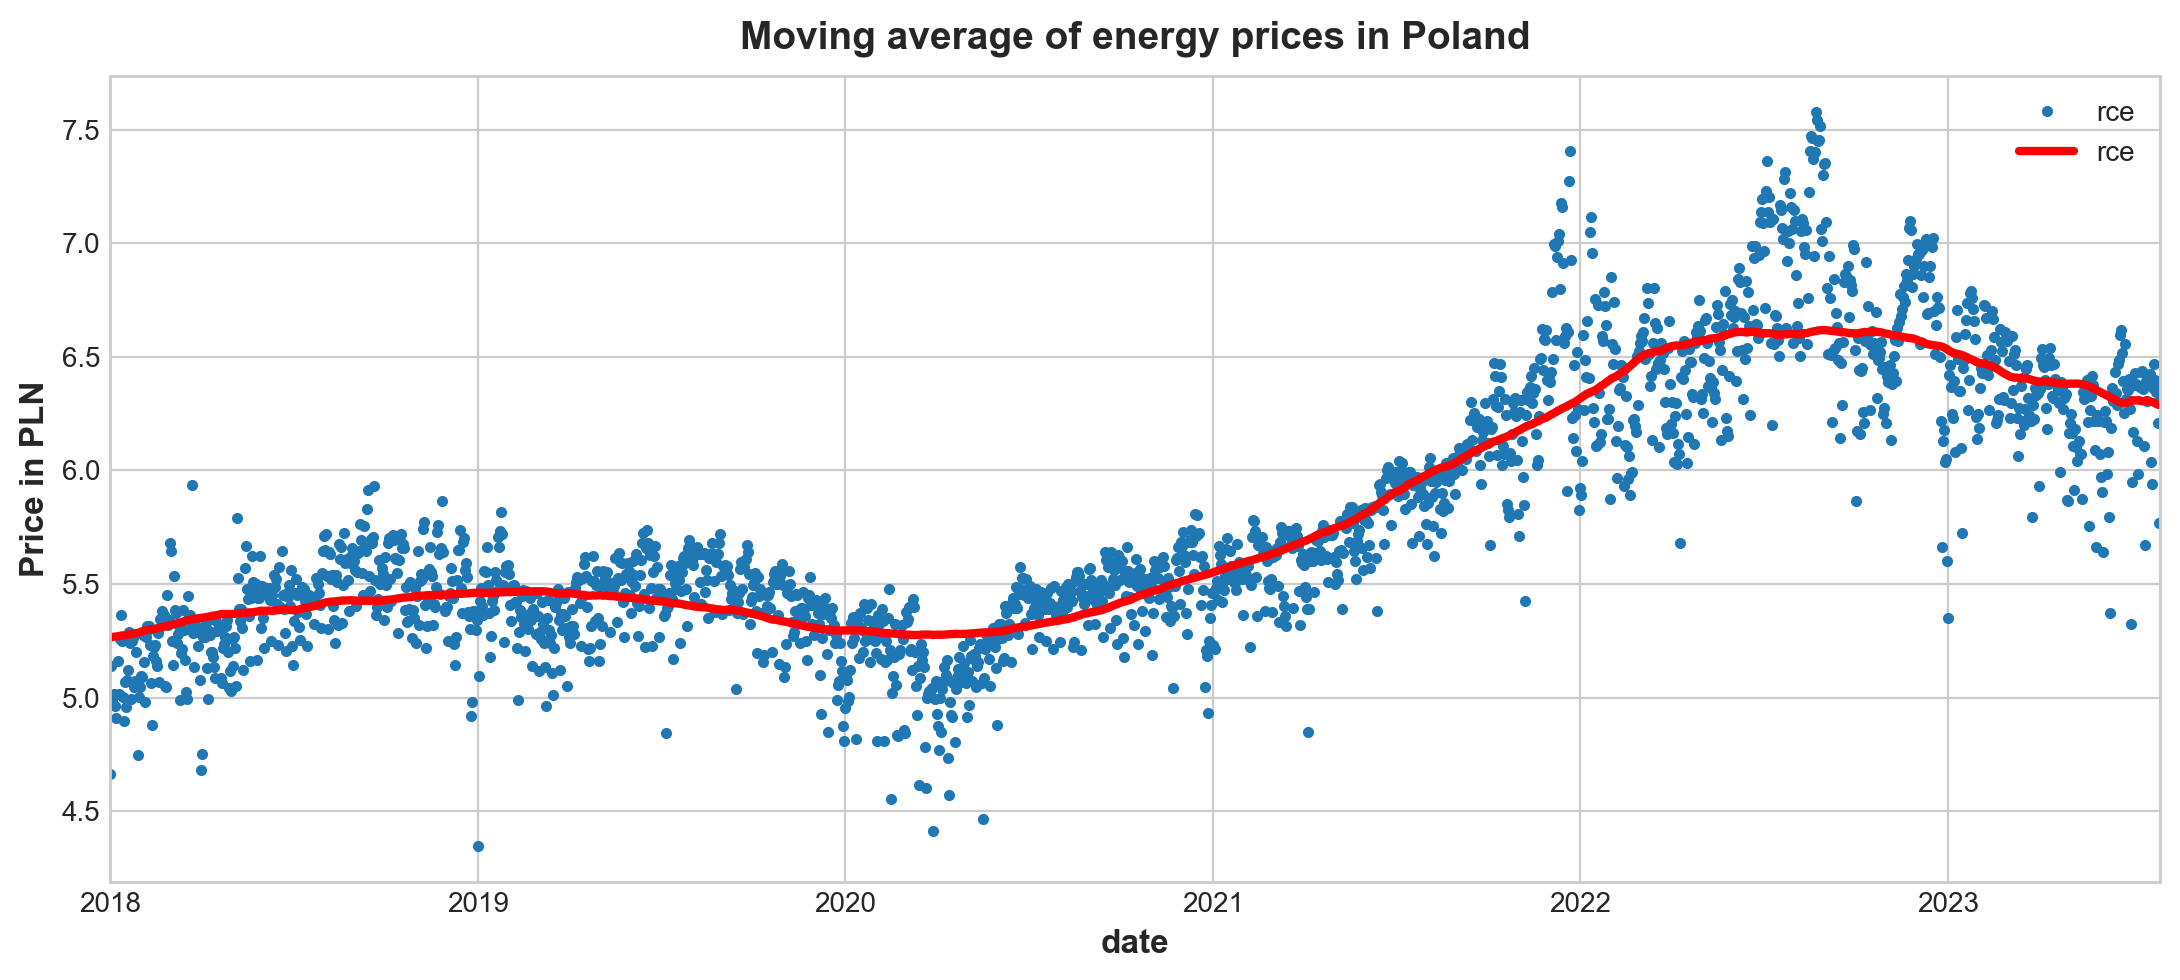

In [37]:
ma = df.rolling(window=365, min_periods=183, center=True).mean()

ax = df.plot(style='.', title='Moving average of energy prices in Poland', ylabel='Price in PLN');
ma.plot(ax=ax, linewidth=3, color='Red');

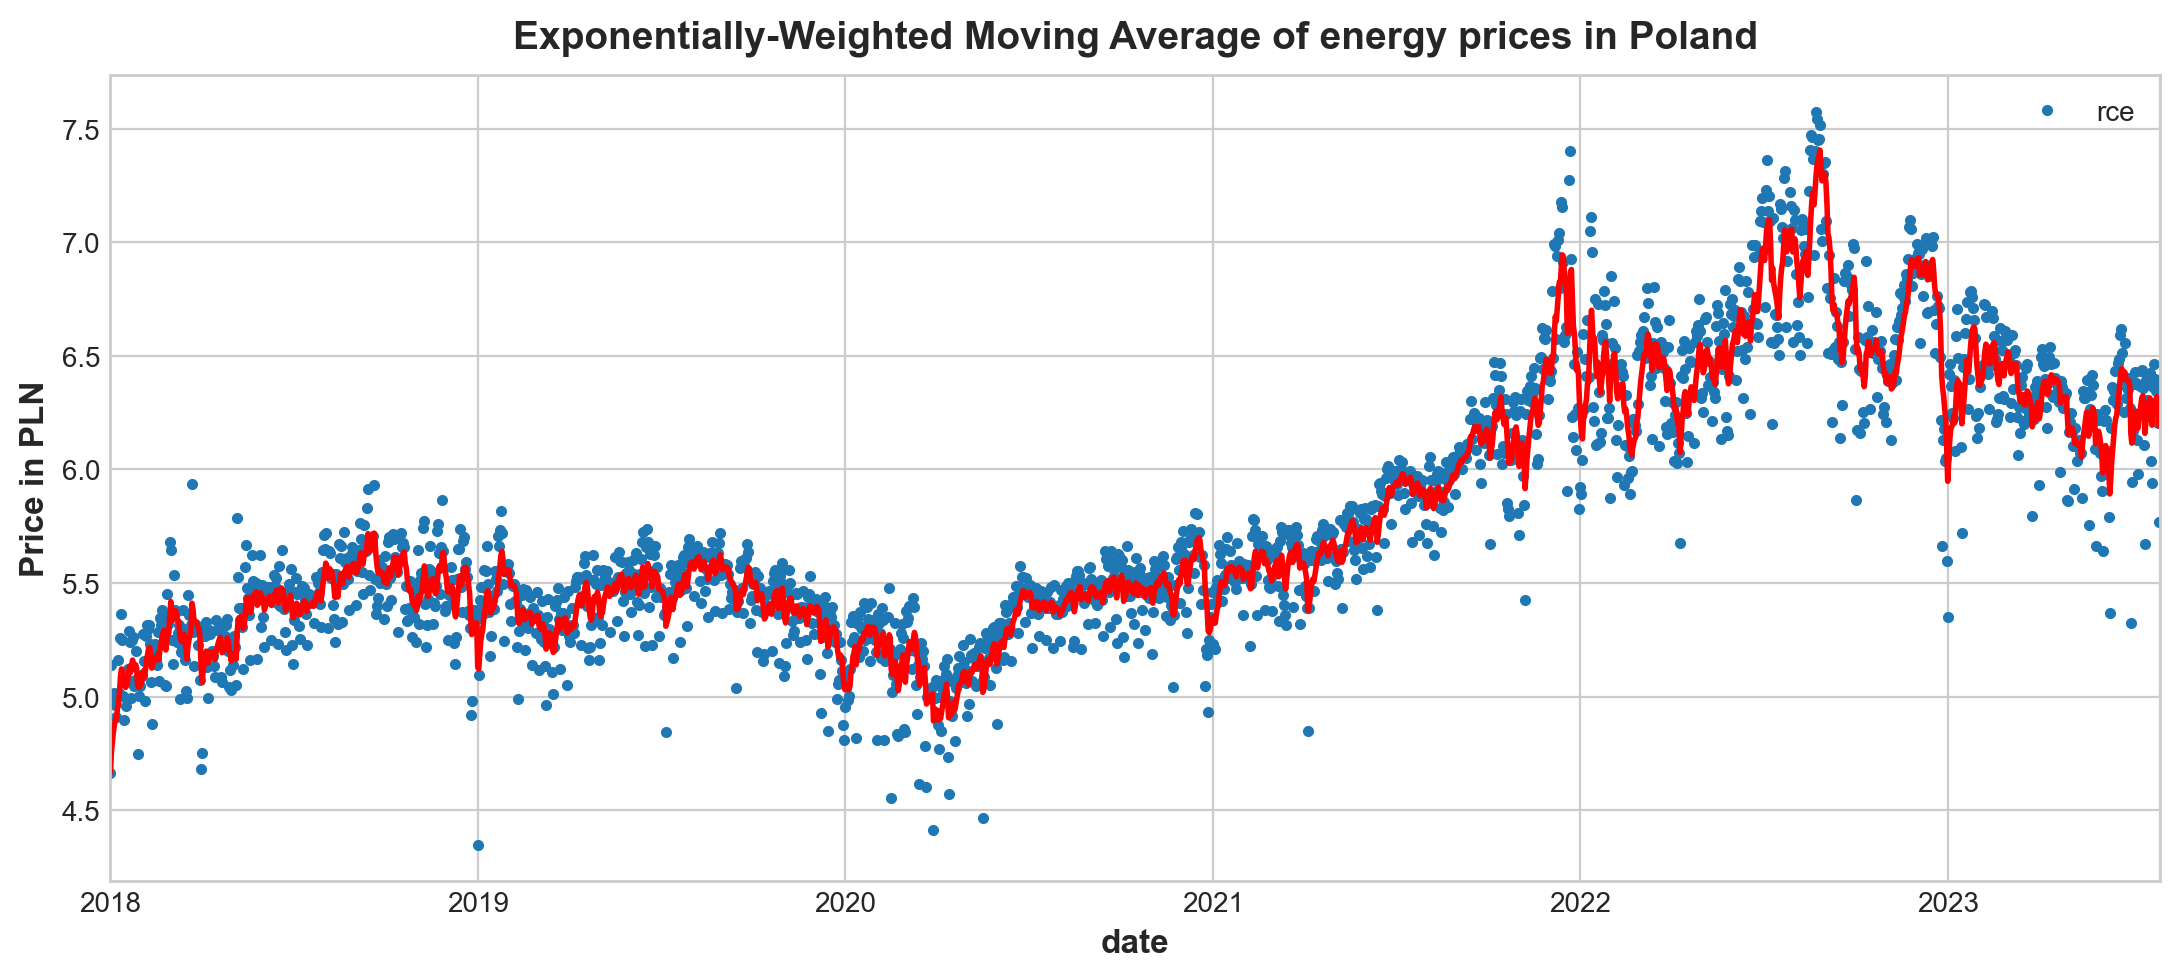

In [38]:
ewm = df['rce'].ewm(alpha=0.2, adjust=False).mean()

ax = df.plot(style='.', title='Exponentially-Weighted Moving Average of energy prices in Poland', ylabel='Price in PLN');
ewm.plot(ax=ax, linewidth=2, color='Red');

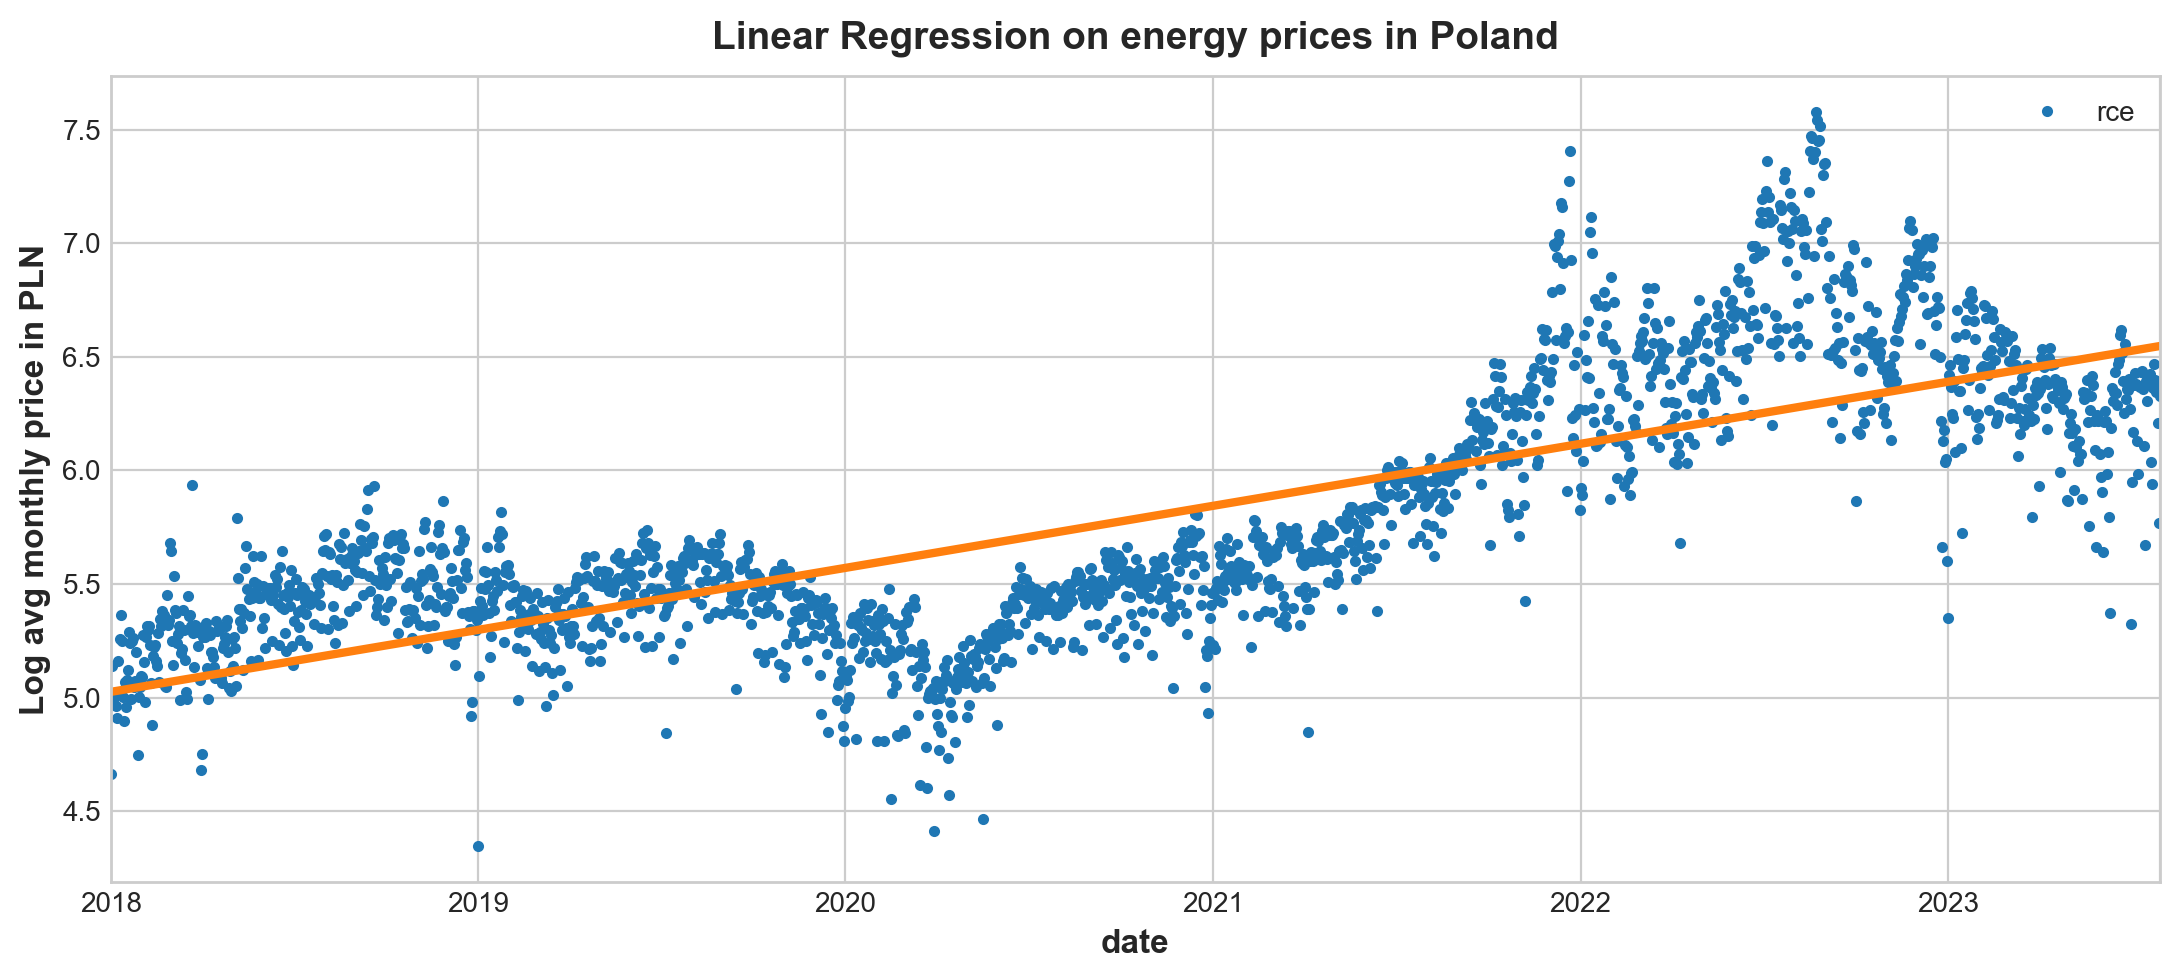

In [39]:
y = df['rce']
model = LinearRegression(fit_intercept=False)

dp = DeterministicProcess(index=df.index, constant=True, order=1)
X = dp.in_sample()

model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=df.index)

ax = df.plot(style='.', title='Linear Regression on energy prices in Poland', ylabel='Log avg monthly price in PLN');
y_pred.plot(ax=ax, linewidth=3);

We can see that data appeared to be seasonal until mid 2021. Let's see if we could do a seasonal forecast, had there been no change to the data structure post mid 2021.

------------------------------------------------------------------------------------------------

# Baseline Models

### Naive Forecast

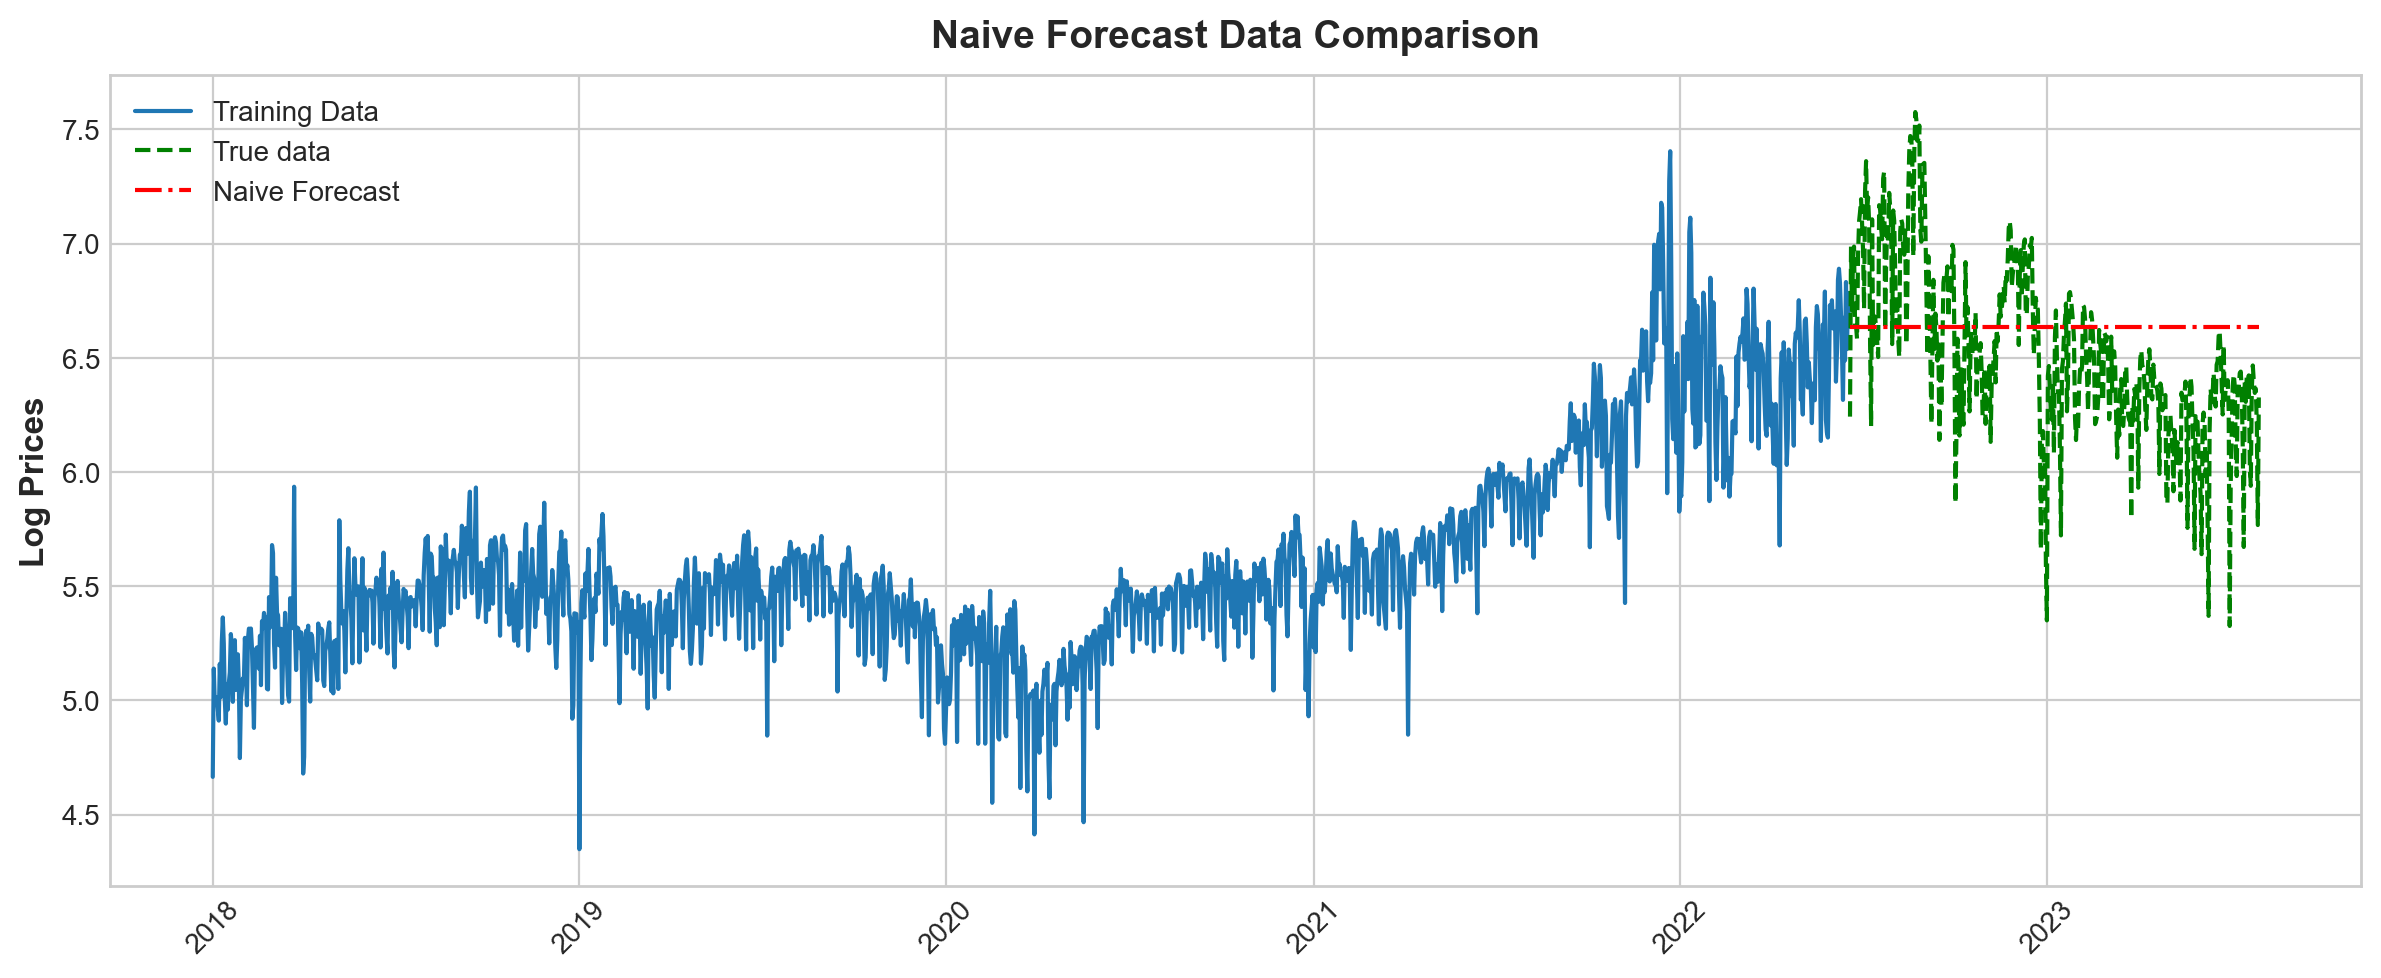

In [40]:
train_len = int(len(df)*0.8)
train = df[0:train_len]
test = df[train_len:]

last_value = train.iloc[-1]['rce']

forecast_dates = test.index

naive_forecast = last_value * len(test)
forecast_df = pd.DataFrame({'date': forecast_dates, 'naive forecast': last_value})
forecast_df.set_index('date', inplace=True)

plt.figure(figsize=(12,5))
plt.plot(train.index, train['rce'], linestyle='-', label='Training Data')
plt.plot(test.index, test['rce'], label='True data', linestyle='--', color='green')
plt.plot(forecast_df.index, forecast_df['naive forecast'], label = 'Naive Forecast', linestyle='-.', color='red')
plt.ylabel('Log Prices')
plt.title('Naive Forecast Data Comparison')
plt.grid(True)
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout();

Let's check how far off is naive forecast with RMSE.

In [41]:
y_true = test.rce
nf_y_pred = forecast_df['naive forecast']

In [42]:
nf_rmse = mse(y_true, nf_y_pred, squared=False)
print(f'RMSE value for a naive forecast: {nf_rmse:.2f}')

RMSE value for a naive forecast: 0.40


### Random Walk

In [43]:
# steps
T = len(test)
# drift
mu = 0.01
# initial price
P0 = last_value

# generate random log returns
r = np.random.randn(T)

last_p = r * mu
cumulative_log_prices = np.cumsum(last_p)
log_prices = np.log(P0) + cumulative_log_prices

#compute prices
prices = np.exp(log_prices)

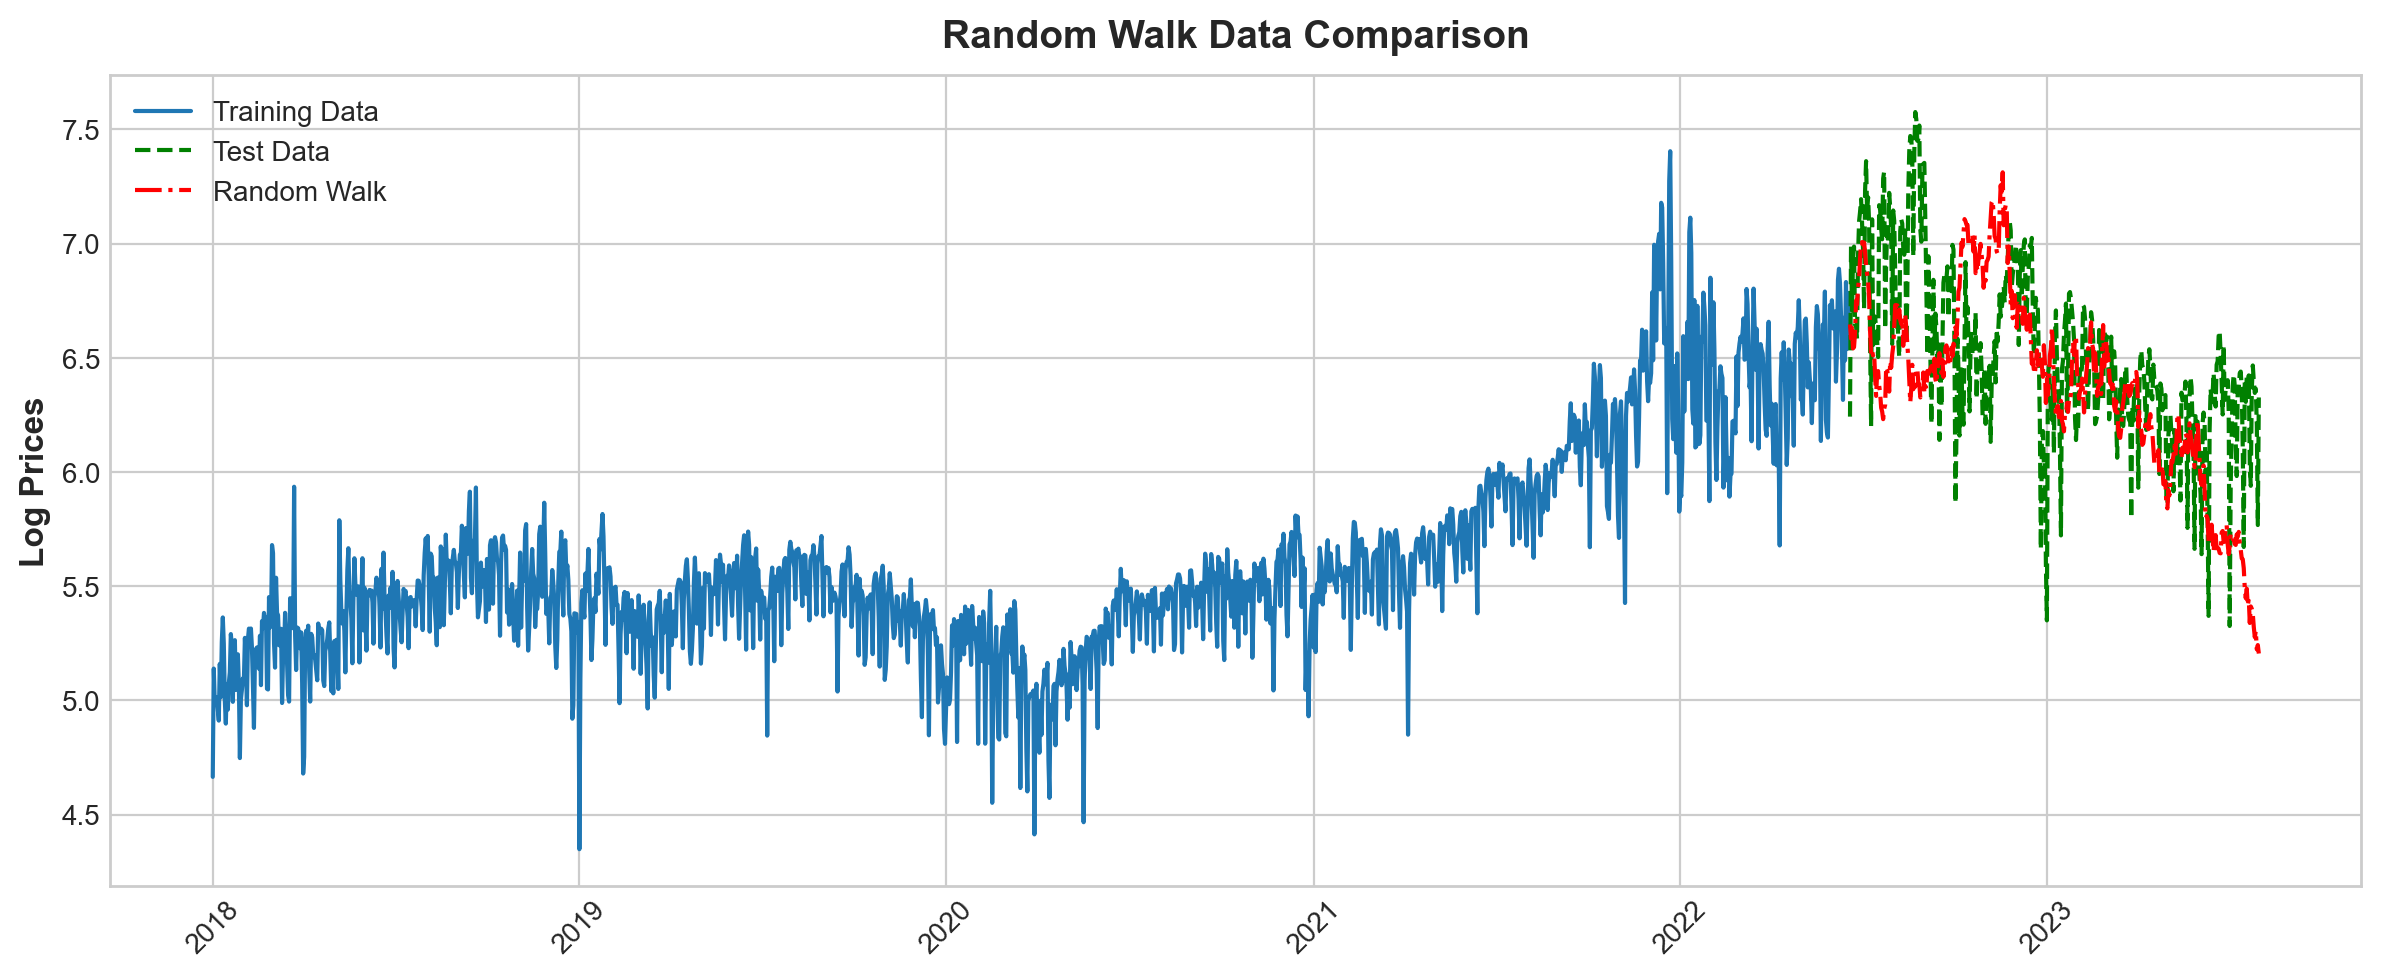

In [44]:
random_walk = pd.DataFrame({'date': test.index, 'rwp': prices})
random_walk.set_index('date', inplace=True)


plt.figure(figsize=(12, 5))
plt.plot(train.index, train['rce'], label='Training Data', linestyle='-')
plt.plot(test.index, test['rce'], label='Test Data', linestyle='--', color='green')
plt.plot(random_walk.index, random_walk['rwp'], label='Random Walk', linestyle='-.', color='red')
plt.ylabel('Log Prices')
plt.title('Random Walk Data Comparison')
plt.grid(True)
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout();

In [45]:
rw_y_pred = random_walk['rwp']

In [46]:
rw_rmse = mse(y_true, rw_y_pred, squared=False)
print(f'RMSE value for a random walk: {rw_rmse:.2f}')

RMSE value for a random walk: 0.46


Random Walk did a pretty good job, considering it's only moving in a random direction. Not far off from Naive Forecast. 

# Forecasting

## AR

Let's check if the simple AR model does a better job than our baseline models.

In [47]:
model = ARIMA(train, order=(7, 0, 0))
fitted_ar = model.fit()

In [48]:
print(fitted_ar.summary())

                               SARIMAX Results                                
Dep. Variable:                    rce   No. Observations:                 1630
Model:                 ARIMA(7, 0, 0)   Log Likelihood                 787.407
Date:                Mon, 04 Sep 2023   AIC                          -1556.813
Time:                        11:34:28   BIC                          -1508.246
Sample:                    01-01-2018   HQIC                         -1538.796
                         - 06-18-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6468      0.228     24.766      0.000       5.200       6.094
ar.L1          0.5188      0.018     28.996      0.000       0.484       0.554
ar.L2         -0.0385      0.023     -1.655      0.0

1. The higher log-likelihood, the better. In this case we have a high value, which is a measure of the goodness of fit of the model.
2. AIC and BIC measure a model quality and complexity. The lower the value, the better.
3. Lags: lag 2, 4, 5 can be discarded, rest of them is perfect due to a 0.0 p-value.
4. Ljung-Box statistics is a test for autocorrelation in the residuals. In our case, a value of 6.21 suggests that there may be still some autocorrelation at lag 1, as the p-value is less than 0.05.
5. Jarque-Bera statistics is a test for normality of residuals. In our case, the p-value of JB test is 0.0, which indicates non-normality of residuals.
6. Heteroscedasticity tests for unequal variance in the residuals. Again, the p-value tells us that there is potential heteroscedasticity.
7. Skewness indicates a slight left skew, and kurtosis tells us that distribution is extremely peaked.

In [49]:
ar_pred = fitted_ar.forecast(steps=len(test))
residuals = test['rce'] - ar_pred

In [50]:
ar = pd.DataFrame({'date': test.index, 'y_pred': ar_pred})

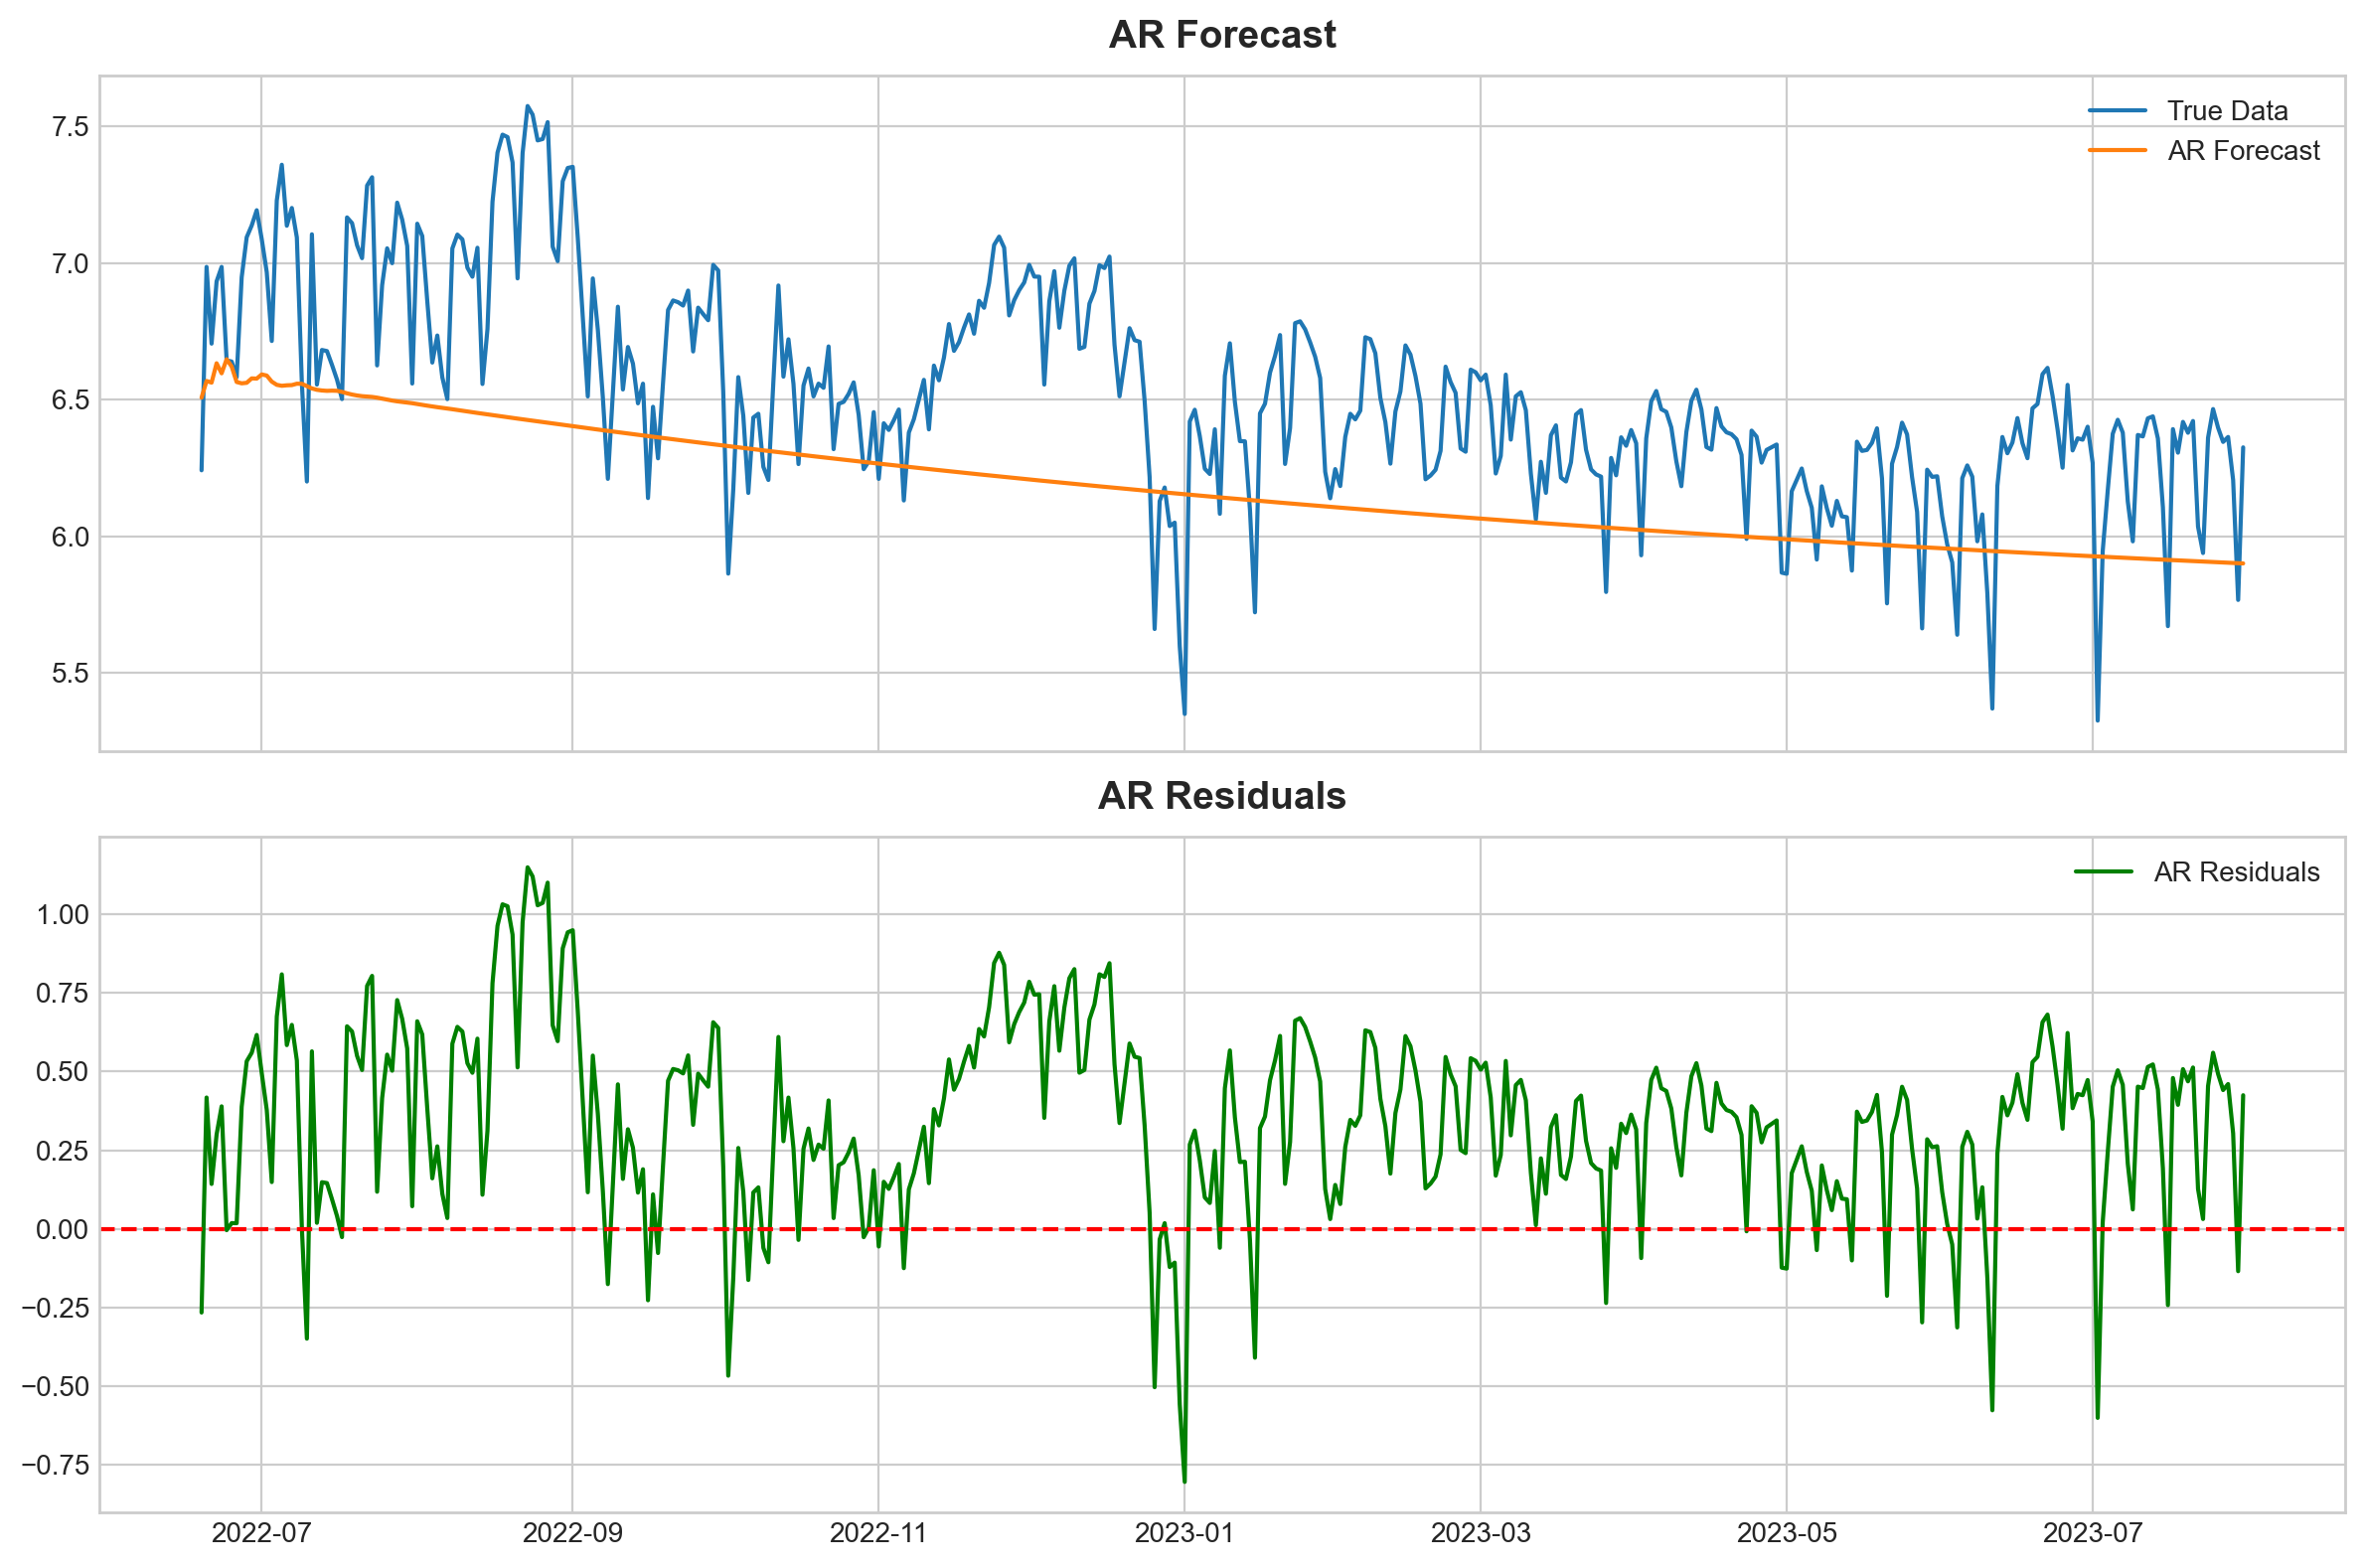

In [51]:
fig, axes = plt.subplots(2, 1, figsize=(12,8), sharex=True)
axes[0].plot(test.index, test['rce'], label = 'True Data')
axes[0].plot(test.index, ar_pred, label = 'AR Forecast')
axes[0].legend()
axes[0].set_title('AR Forecast')

axes[1].plot(residuals, label='AR Residuals', color='green')
axes[1].axhline(0, color='r', linestyle ='--');
axes[1].legend()
axes[1].set_title('AR Residuals')
plt.legend()
plt.tight_layout();

We see that residuals follow the same exact path of the test data. This indicates that the AR model did not capture certain complexities of the data. Residuals should be a white noise - uncorrelated and normally distributed).

In [52]:
ar_rmse = mse(y_true, ar_pred, squared=False)
print(f'RMSE value for the AR model: {ar_rmse:.2f}')

RMSE value for the AR model: 0.45


### ARMA

Now that we know, that the AR model does not capture certain complexities of the data, let's try expanding it to ARMA.

In [53]:
model = ARIMA(train, order=(7, 0, 1))
fitted_arma = model.fit()

In [54]:
print(fitted_arma.summary())

                               SARIMAX Results                                
Dep. Variable:                    rce   No. Observations:                 1630
Model:                 ARIMA(7, 0, 1)   Log Likelihood                 814.533
Date:                Mon, 04 Sep 2023   AIC                          -1609.066
Time:                        11:34:30   BIC                          -1555.103
Sample:                    01-01-2018   HQIC                         -1589.047
                         - 06-18-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6439      0.213     26.452      0.000       5.226       6.062
ar.L1          0.1480      0.040      3.737      0.000       0.070       0.226
ar.L2          0.1888      0.030      6.371      0.0

We can tell that ARMA gives us a slightly better measures of goodness of fit of the model, but on the other hand the residuals are a subject of this model not working.

In [55]:
arma_pred = fitted_arma.forecast(steps=len(test))
residuals = y_true - arma_pred

In [56]:
arma = pd.DataFrame({'date': test.index, 'y_pred': arma_pred})
arma.set_index('date', inplace=True)

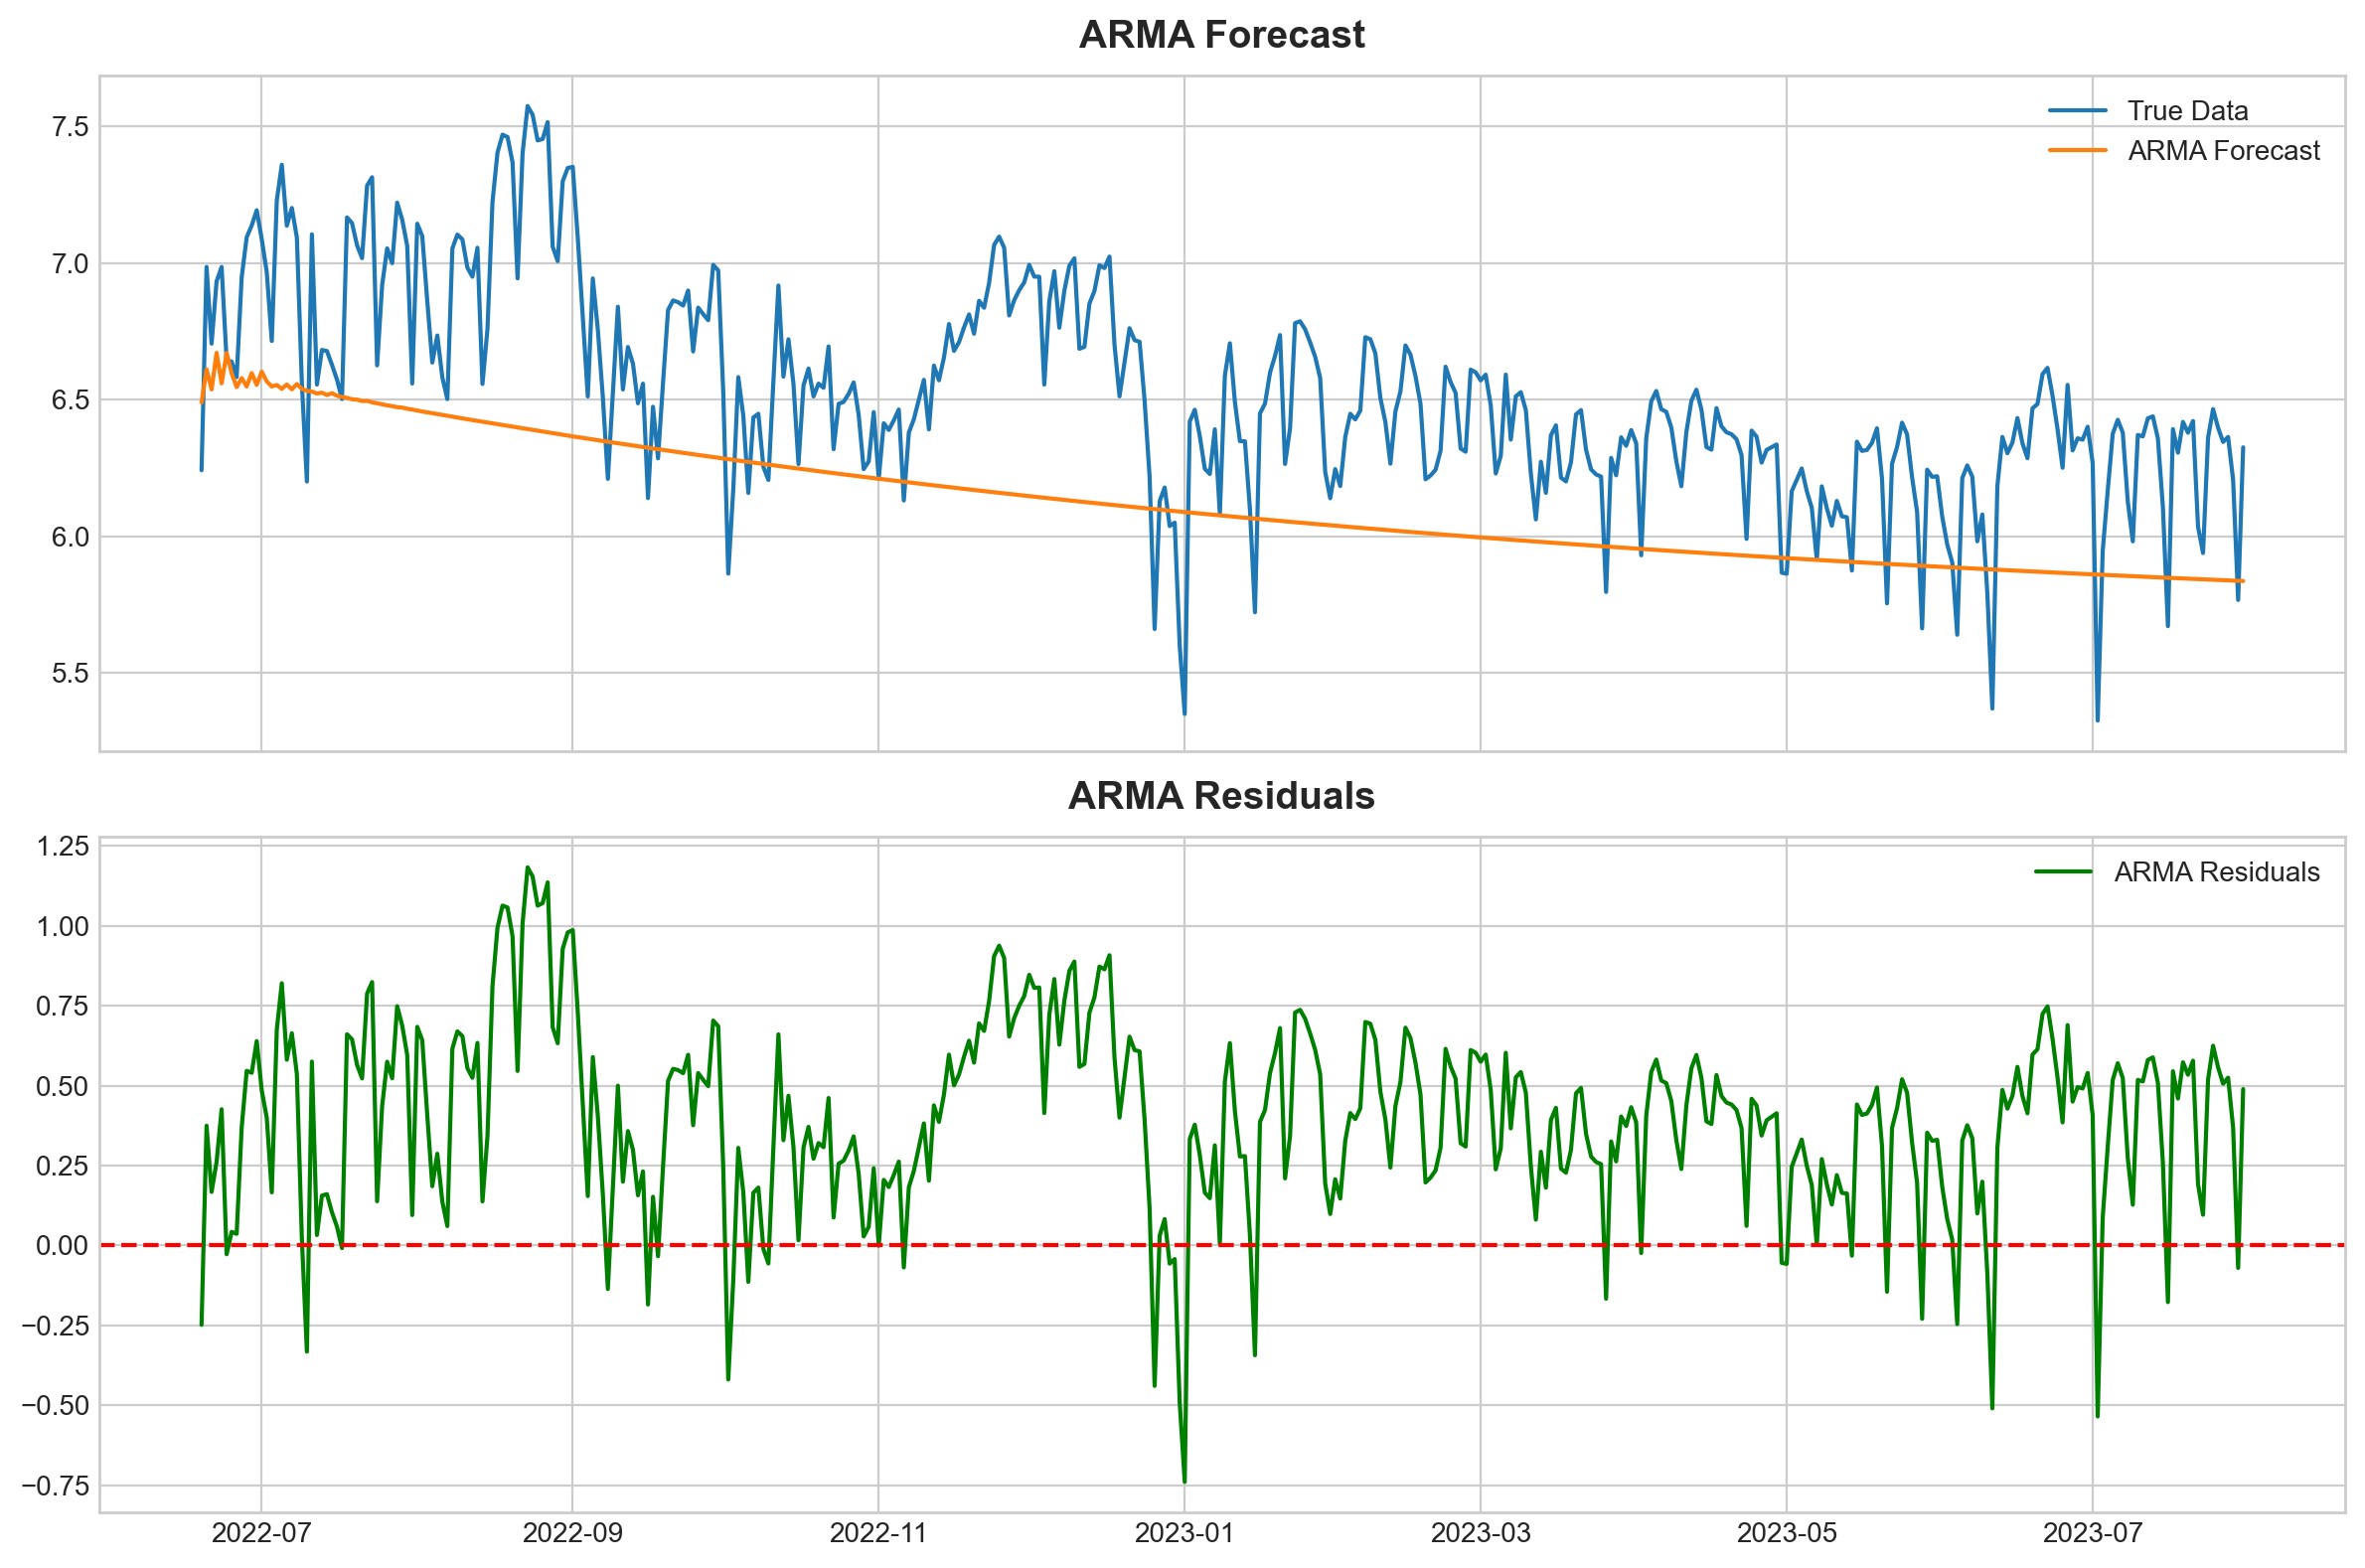

In [57]:
fig, axes = plt.subplots(2, 1, figsize=(12,8), sharex=True)
axes[0].plot(test.index, test['rce'], label = 'True Data')
axes[0].plot(test.index, arma_pred, label = 'ARMA Forecast')
axes[0].legend()
axes[0].set_title('ARMA Forecast')

axes[1].plot(residuals, label='ARMA Residuals', color='green')
axes[1].axhline(0, color='r', linestyle ='--');
axes[1].legend()
axes[1].set_title('ARMA Residuals')
plt.legend()
plt.tight_layout();

In [58]:
arma_rmse = mse(y_true, arma_pred, squared=False)
print(f'RMSE value for ARMA: {arma_rmse:.2f}')

RMSE value for ARMA: 0.49


Adding the moving average element to the AR model unfortunately did not improve the results.

### Simple Exponential Smoothing

In [59]:
ses = SimpleExpSmoothing(train, initialization_method='legacy-heuristic')

In [60]:
model = ses.fit(optimized=True)

In [61]:
ses_forecast = model.forecast(len(test))

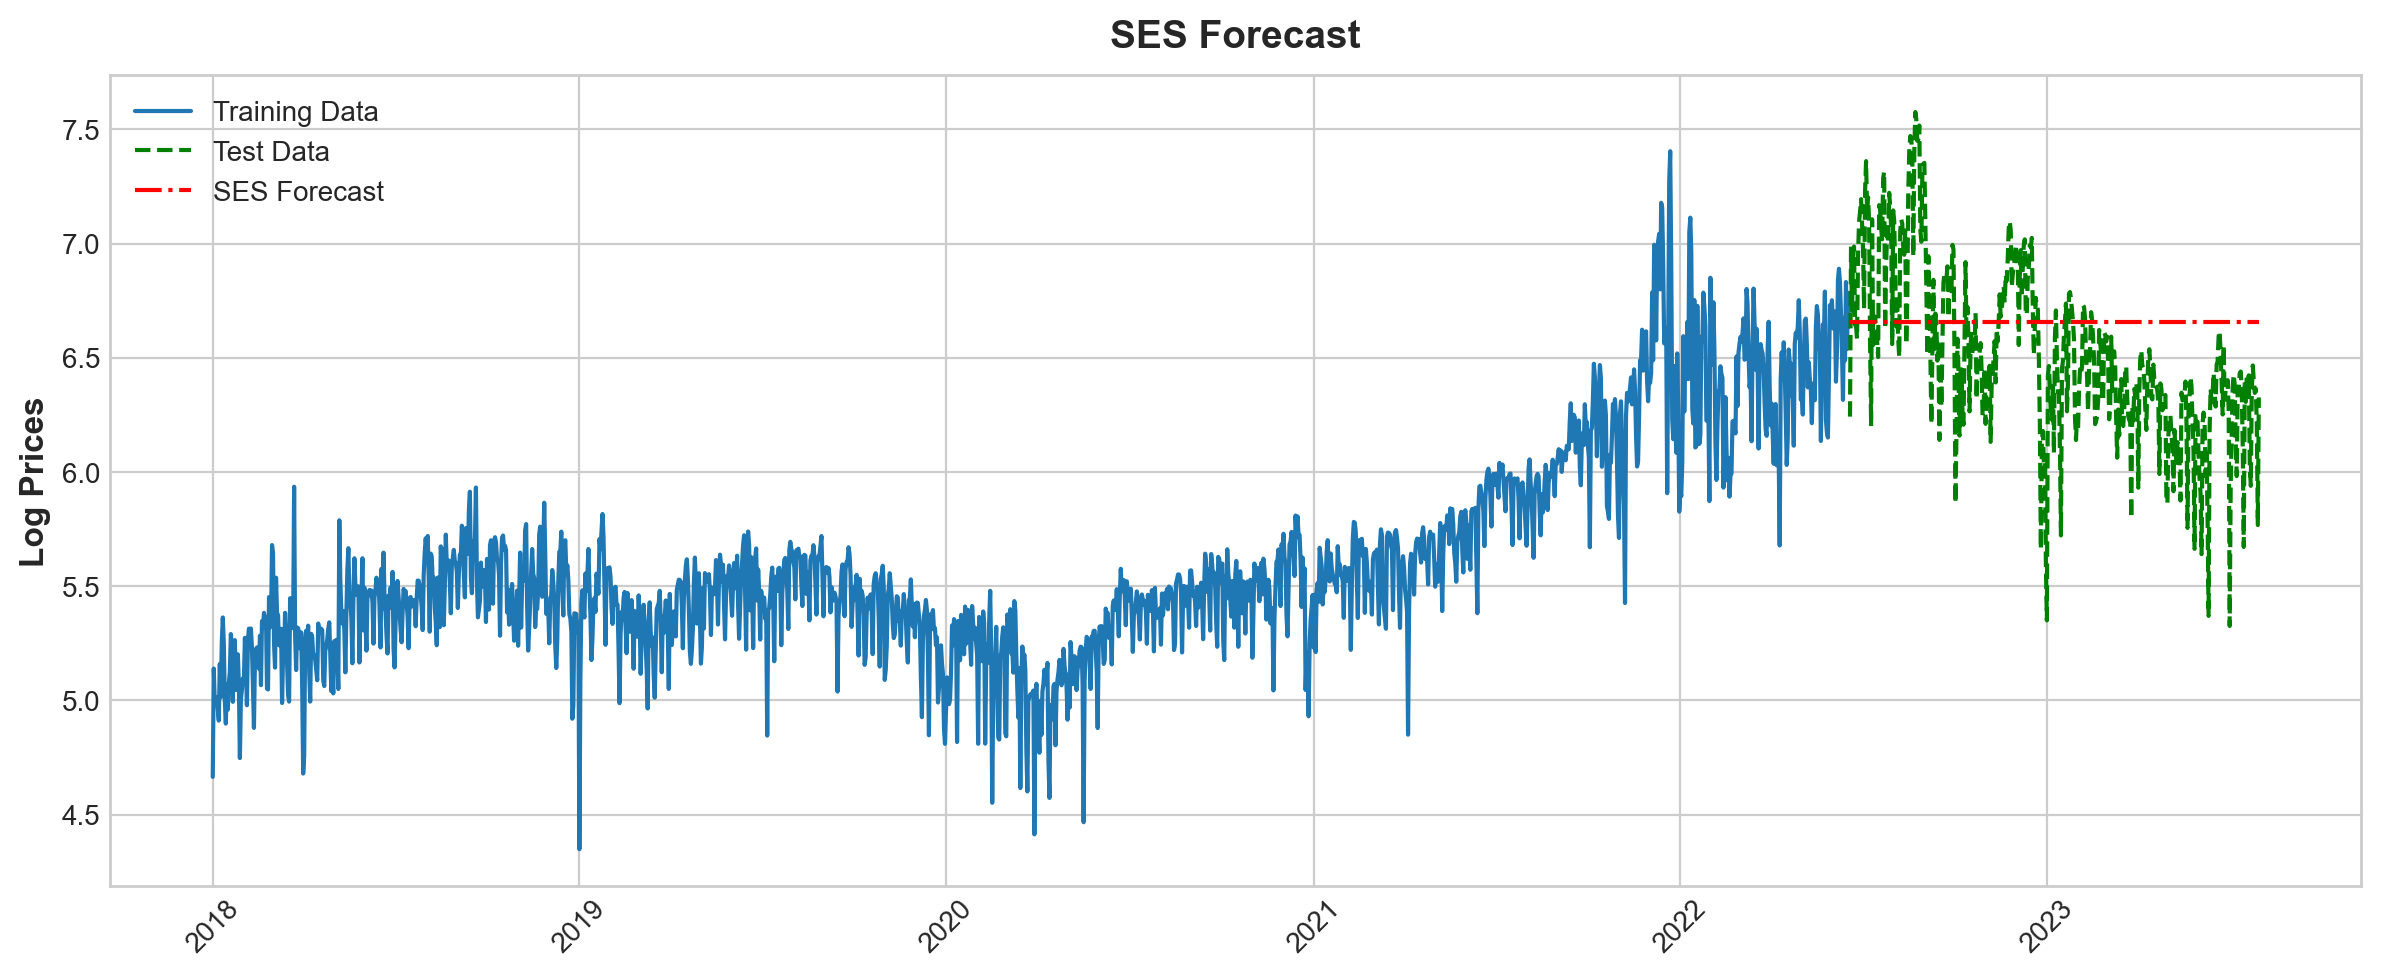

In [62]:
plt.figure(figsize=(12, 5))
plt.plot(train.index, train['rce'], label='Training Data', linestyle='-')
plt.plot(test.index, test['rce'], label='Test Data', linestyle='--', color='green')
plt.plot(ses_forecast, label='SES Forecast', linestyle='-.', color='red')
plt.ylabel('Log Prices')
plt.title('SES Forecast')
plt.grid(True)
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout();

In [63]:
print(f'Chosen smoothing level: {model.params["smoothing_level"]:.2f}')

Chosen smoothing level: 0.31


In [64]:
ses_rmse = mse(y_true, ses_forecast, squared=False)
print(f'RMSE value for Simple Exponential Smoothing: {ses_rmse:.2f}')

RMSE value for Simple Exponential Smoothing: 0.40


It looks like the RMSe value for simple exponential smoothing and naive forecasts are the same.
Are the values also the same?

In [65]:
print('Naive forecast value')
print(f'{last_value:.2f}')
print('SES value')
print(f'{ses_forecast[0]:.2f}')

Naive forecast value
6.64
SES value
6.66


A takeaway could be that Simple Exponential Smoothing method is too simple for this data, which appears to be random and noisy.

### XGBOOST

As this is a hybrid technique of xgboost and regression, we will add more data to our dataset, like day of week, so the model can learn better.

In [66]:
dfx = df.copy()
dfx['day_of_week'] = dfx.index.day_of_week
dfx['month'] = dfx.index.month
dfx['quarter'] = dfx.index.quarter
dfx['year'] = dfx.index.year

In [67]:
trainx_len = int(len(dfx)*0.8)
trainx = dfx[0:trainx_len]
testx = dfx[trainx_len:]

In [68]:
X_train = trainx.drop(labels='rce', axis=1)
y_train = trainx['rce']
X_test = testx.drop(labels='rce', axis=1)
y_test = testx['rce']

In [69]:
reg = xgb.XGBRegressor(n_estimators=6000, learning_rate = 0.001)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=1000);

[0]	validation_0-rmse:5.11598	validation_1-rmse:6.02855
[1000]	validation_0-rmse:1.89689	validation_1-rmse:2.32088
[2000]	validation_0-rmse:0.71958	validation_1-rmse:0.97851
[3000]	validation_0-rmse:0.30253	validation_1-rmse:0.49072
[4000]	validation_0-rmse:0.17463	validation_1-rmse:0.36227
[5000]	validation_0-rmse:0.14573	validation_1-rmse:0.34475
[5999]	validation_0-rmse:0.13985	validation_1-rmse:0.34467


XGB stops improving upon 0.14 RMSE on training validation and 0.34 on testing validation.

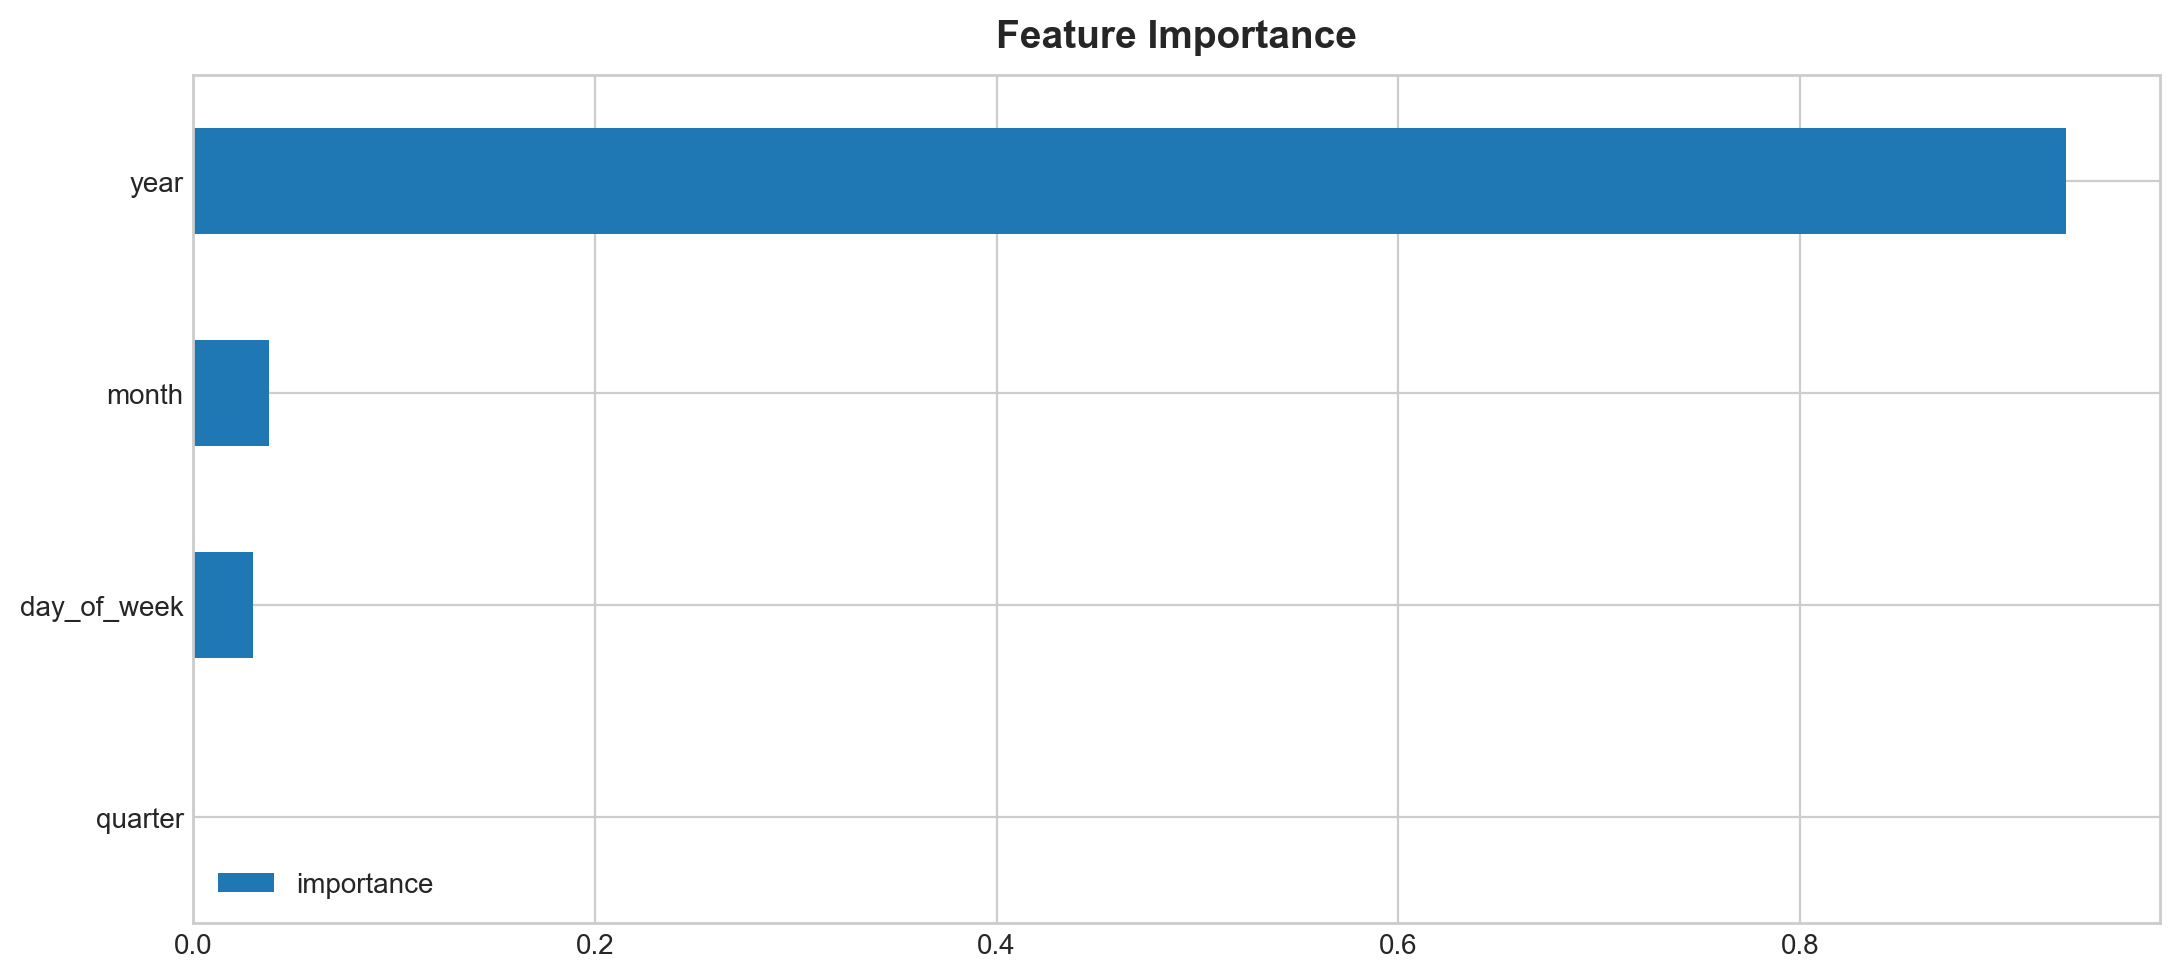

In [70]:
pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance']).sort_values('importance').plot(kind='barh', title='Feature Importance');

We can see how important the year feature is. Almost as if everything depended on it. We can guess that's because of certain events happening lately in Eastern Europe.

In [71]:
xgb_forecast = reg.predict(X_test)

In [72]:
xgb = pd.DataFrame({'date': testx.index, 'y_pred': xgb_forecast})
xgb.set_index('date', inplace=True)

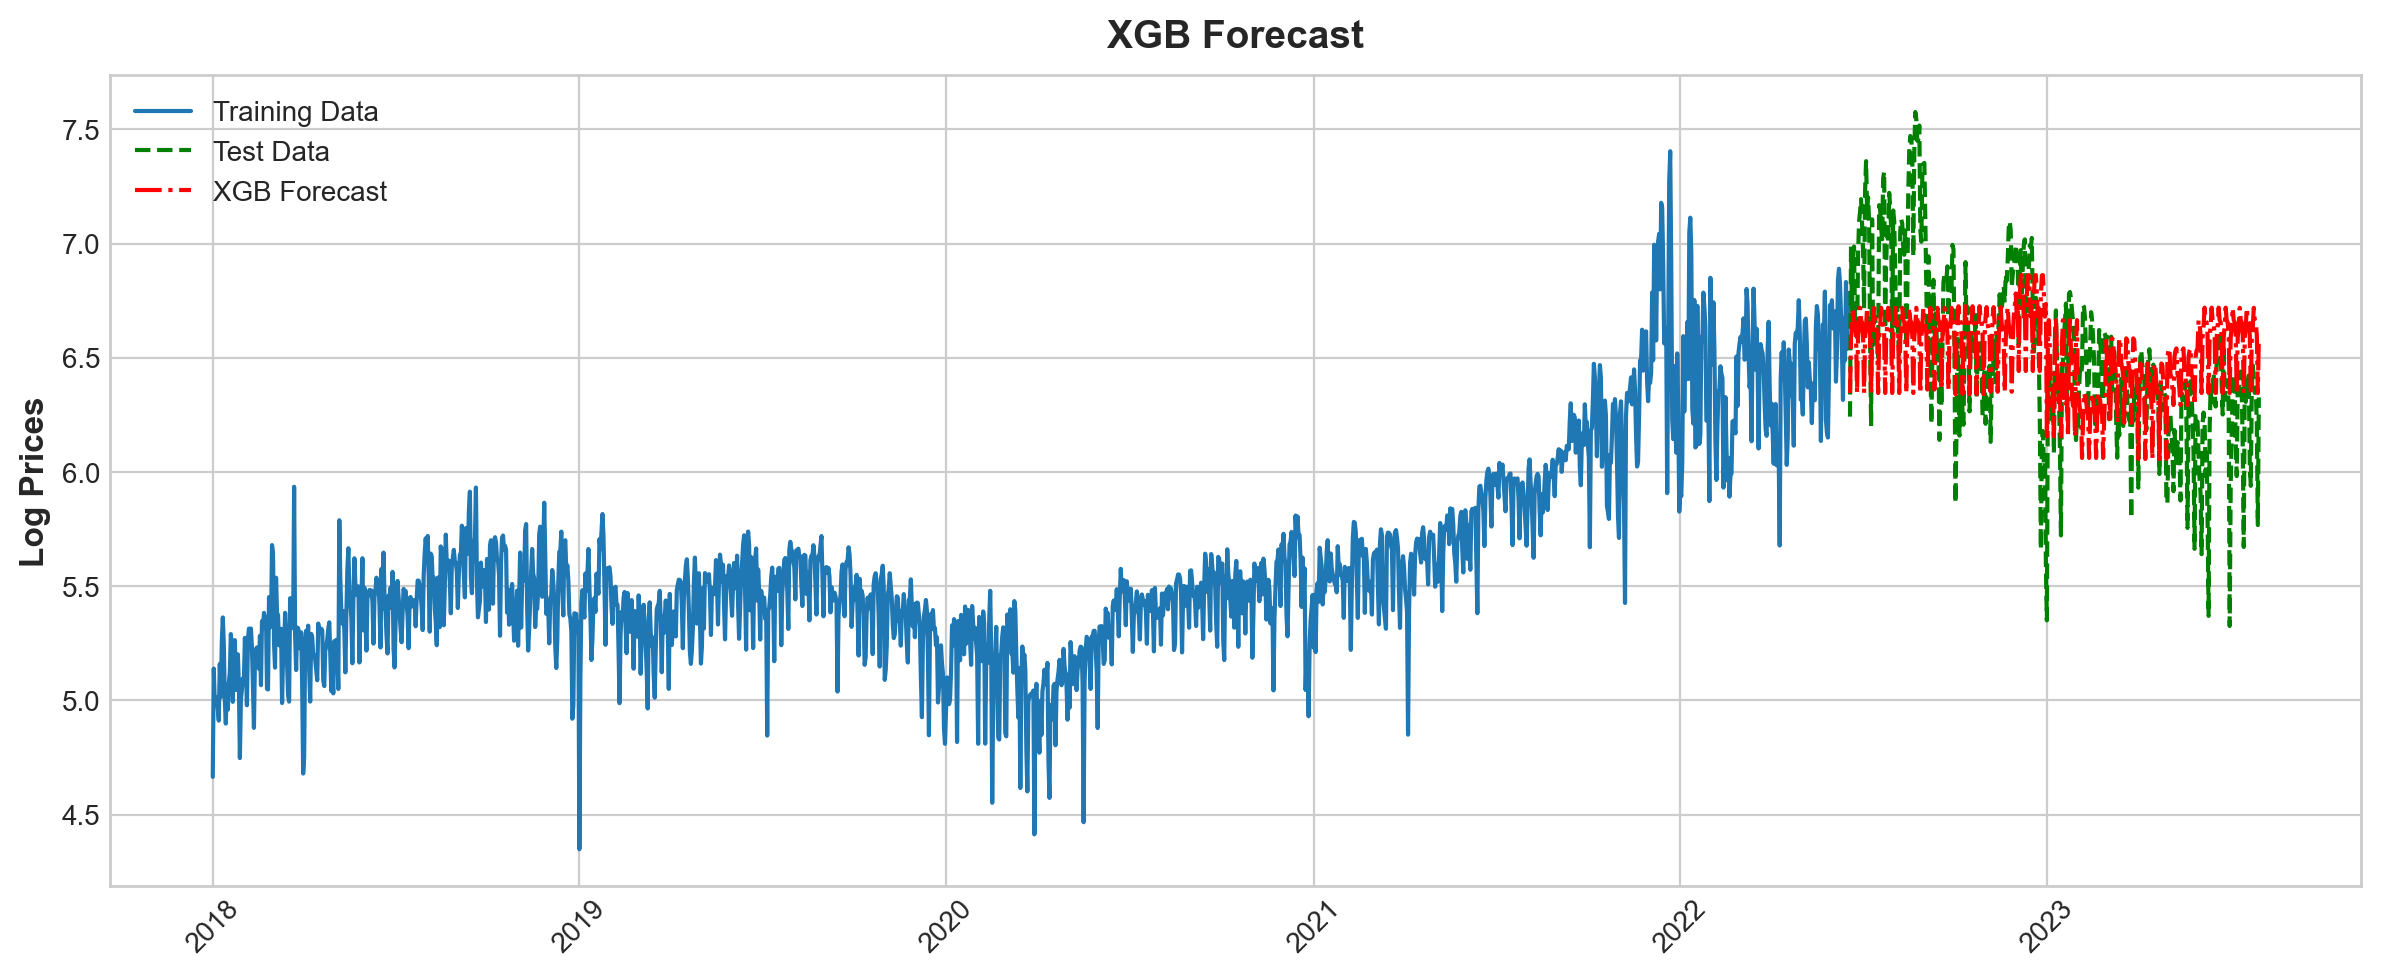

In [73]:
plt.figure(figsize=(12, 5))
plt.plot(train.index, trainx['rce'], label='Training Data', linestyle='-')
plt.plot(test.index, testx['rce'], label='Test Data', linestyle='--', color='green')
plt.plot(xgb.index, xgb_forecast, label='XGB Forecast', linestyle='-.', color='red')
plt.ylabel('Log Prices')
plt.title('XGB Forecast')
plt.grid(True)
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout();

In [74]:
xgb_rmse = mse(y_true, xgb_forecast, squared=False)
print(f'RMSE value for XGB Regression: {xgb_rmse:.2f}')

RMSE value for XGB Regression: 0.34


We can see that finally, XGB did a better job than naive forecast. Very low learning rate was used to ensure that the data would not overfit.

## Bonus: Seasonal Forecast

What if data remained stationary and there was no conflict in the Eastern Europe? Can we try to model a seasonal forecast?

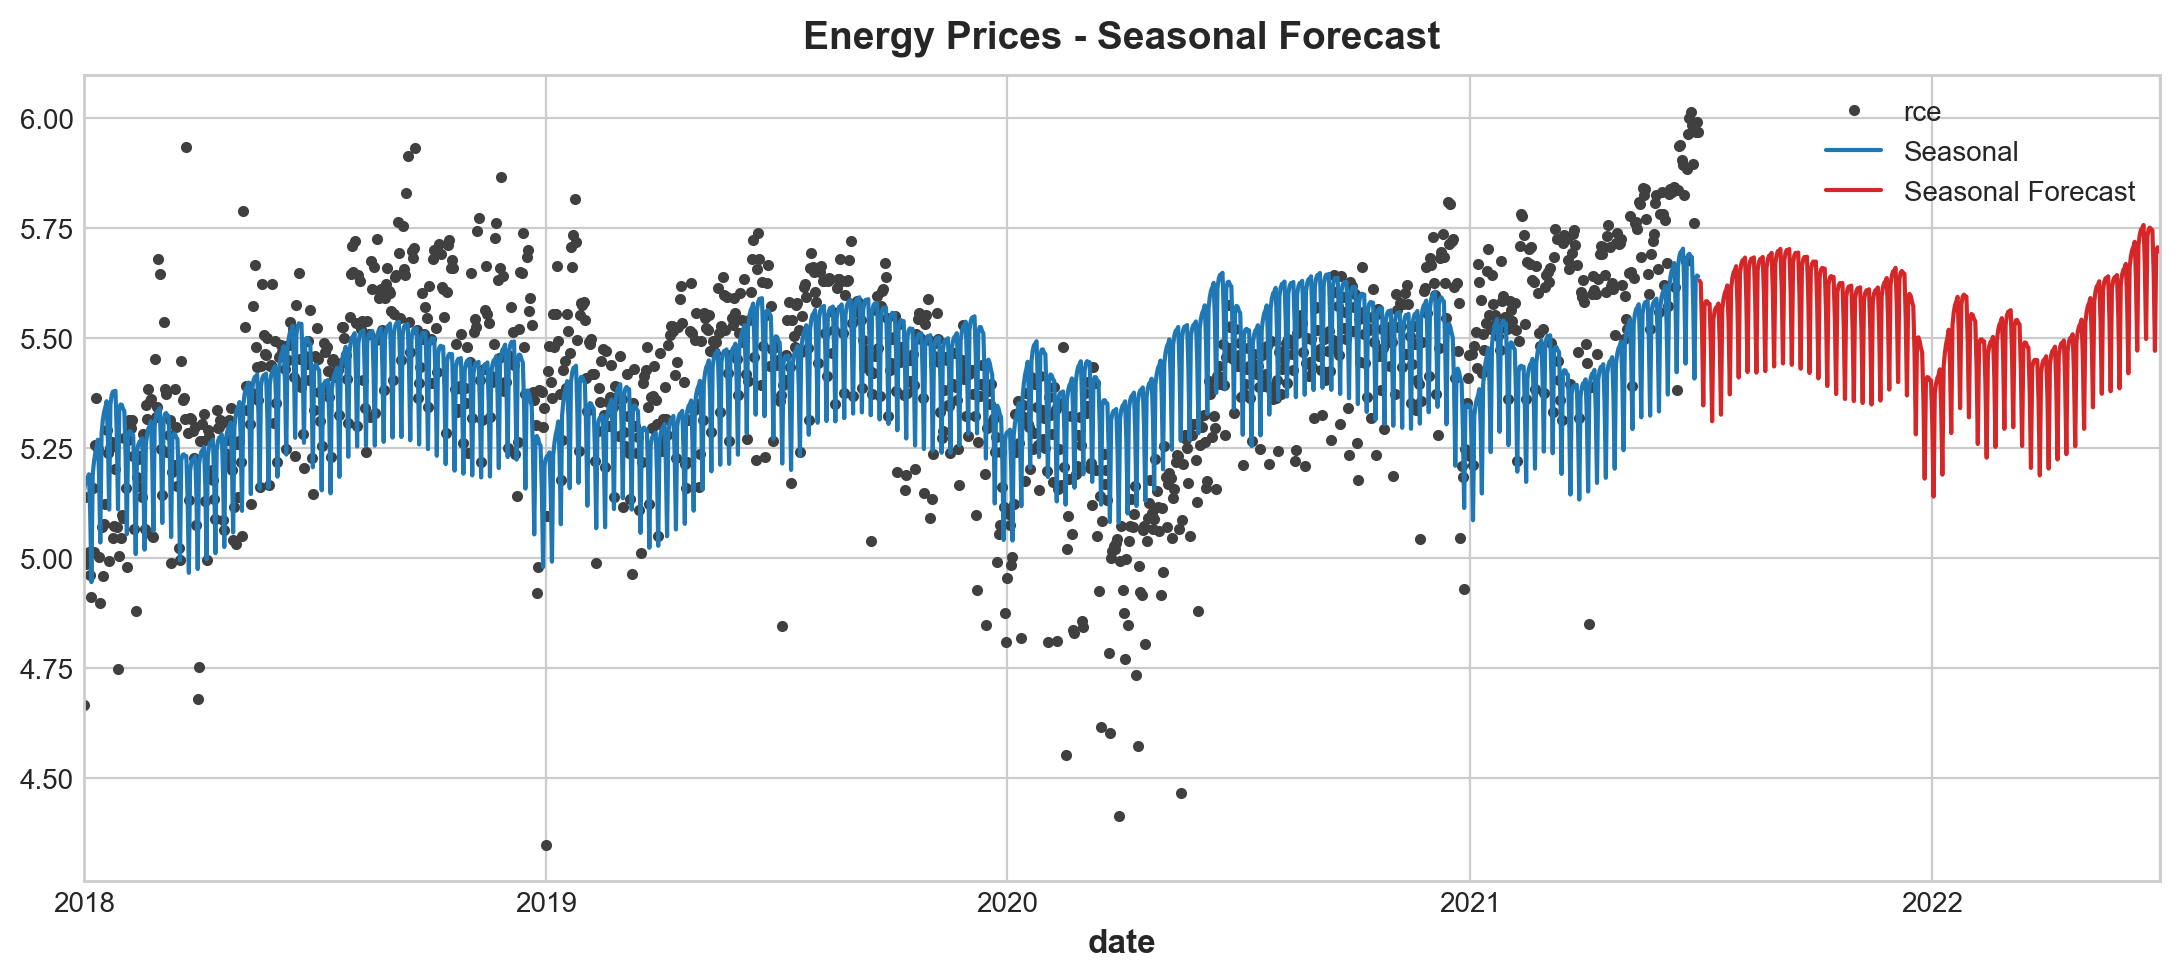

In [75]:
df_short = df.copy()
df_short = df_short.loc[:'2021-06']

fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for Annual seasonality

dp = DeterministicProcess(
    index=df_short.index,
    constant=True,               
    order=1,                     
    seasonal=True,               
    additional_terms=[fourier],  
    drop=True,                   
)

X = dp.in_sample() 

y = df_short["rce"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)

X_fore = dp.out_of_sample(365)

y_fore = pd.Series(model.predict(X_fore), index=X_fore.index);

ax = y.plot(color='0.25', style='.', title="Energy Prices - Seasonal Forecast");
ax = y_pred.plot(ax=ax, label="Seasonal");
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3');
ax.legend();

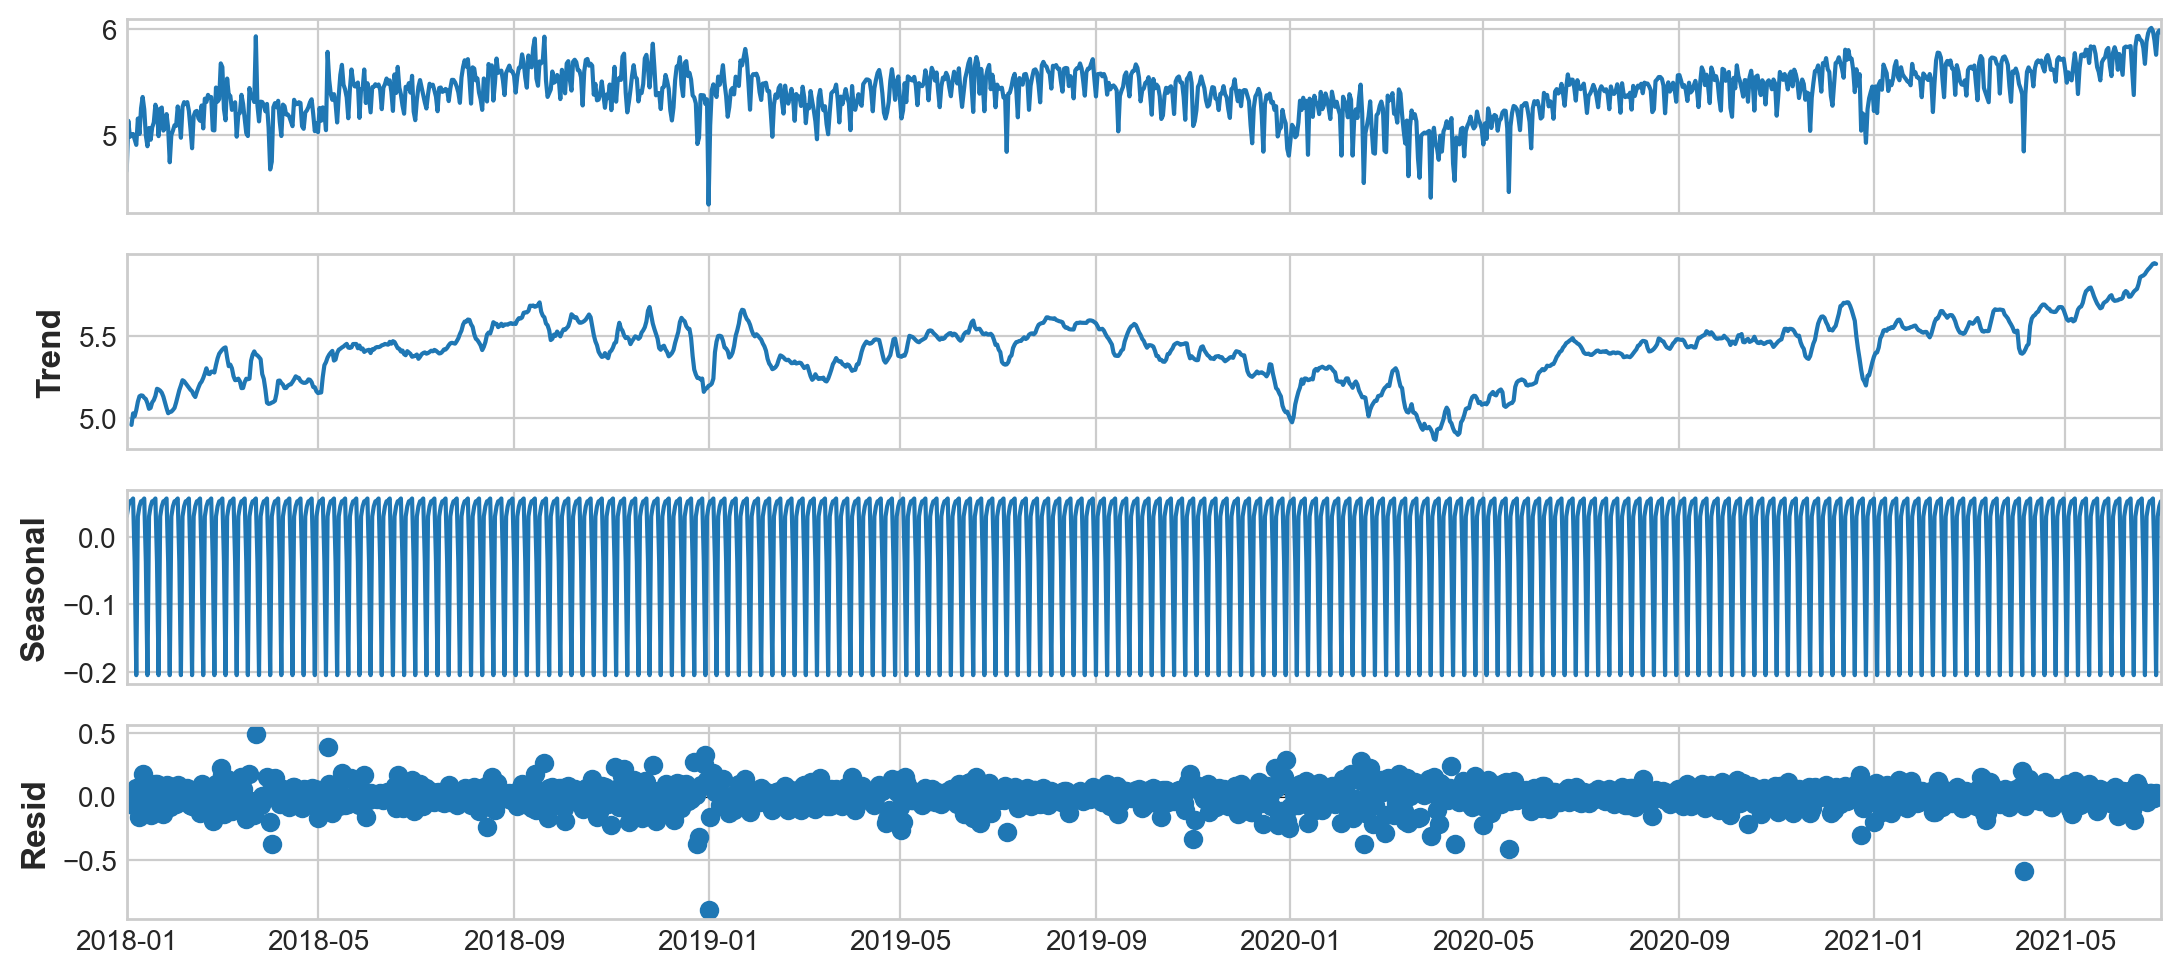

In [76]:
decomp_short = seasonal_decompose(df_short)
decomp_short.plot();

# Key takeaways

The time series we're dealing with is non-stationary. We could see that prior to creating any model just by looking at data or doing an Augmented Dickey-Fuller test. However, prior to certain events happening in Eastern Europe since late 2021 data looked like it would be stationary and seasonal. That's why I've decided to also check these models.
Looks like these the task is impossible, even with hybrid, advanced methods as XGB we're getting poor results, not much better than just a naive forecast.

Full data is too random and noisy, it does not follow any particular trend or seasonality, it's heteroskedastic and unstable.

War and politics have a very strong impact on energy prices.

In [105]:
data = [nf_rmse, rw_rmse, ar_rmse, arma_rmse, ses_rmse, xgb_rmse]
models = ['Naive Forecast', 'Random Walk', 'Autoregressive', 'Autoregressive Moving Average', 'Simple Exponential Smoothing',
          'XGB Regression']

results = pd.DataFrame(data=data, index=models, columns=['RMSE']).sort_values('RMSE', ascending=False).round(3)

### Final Results

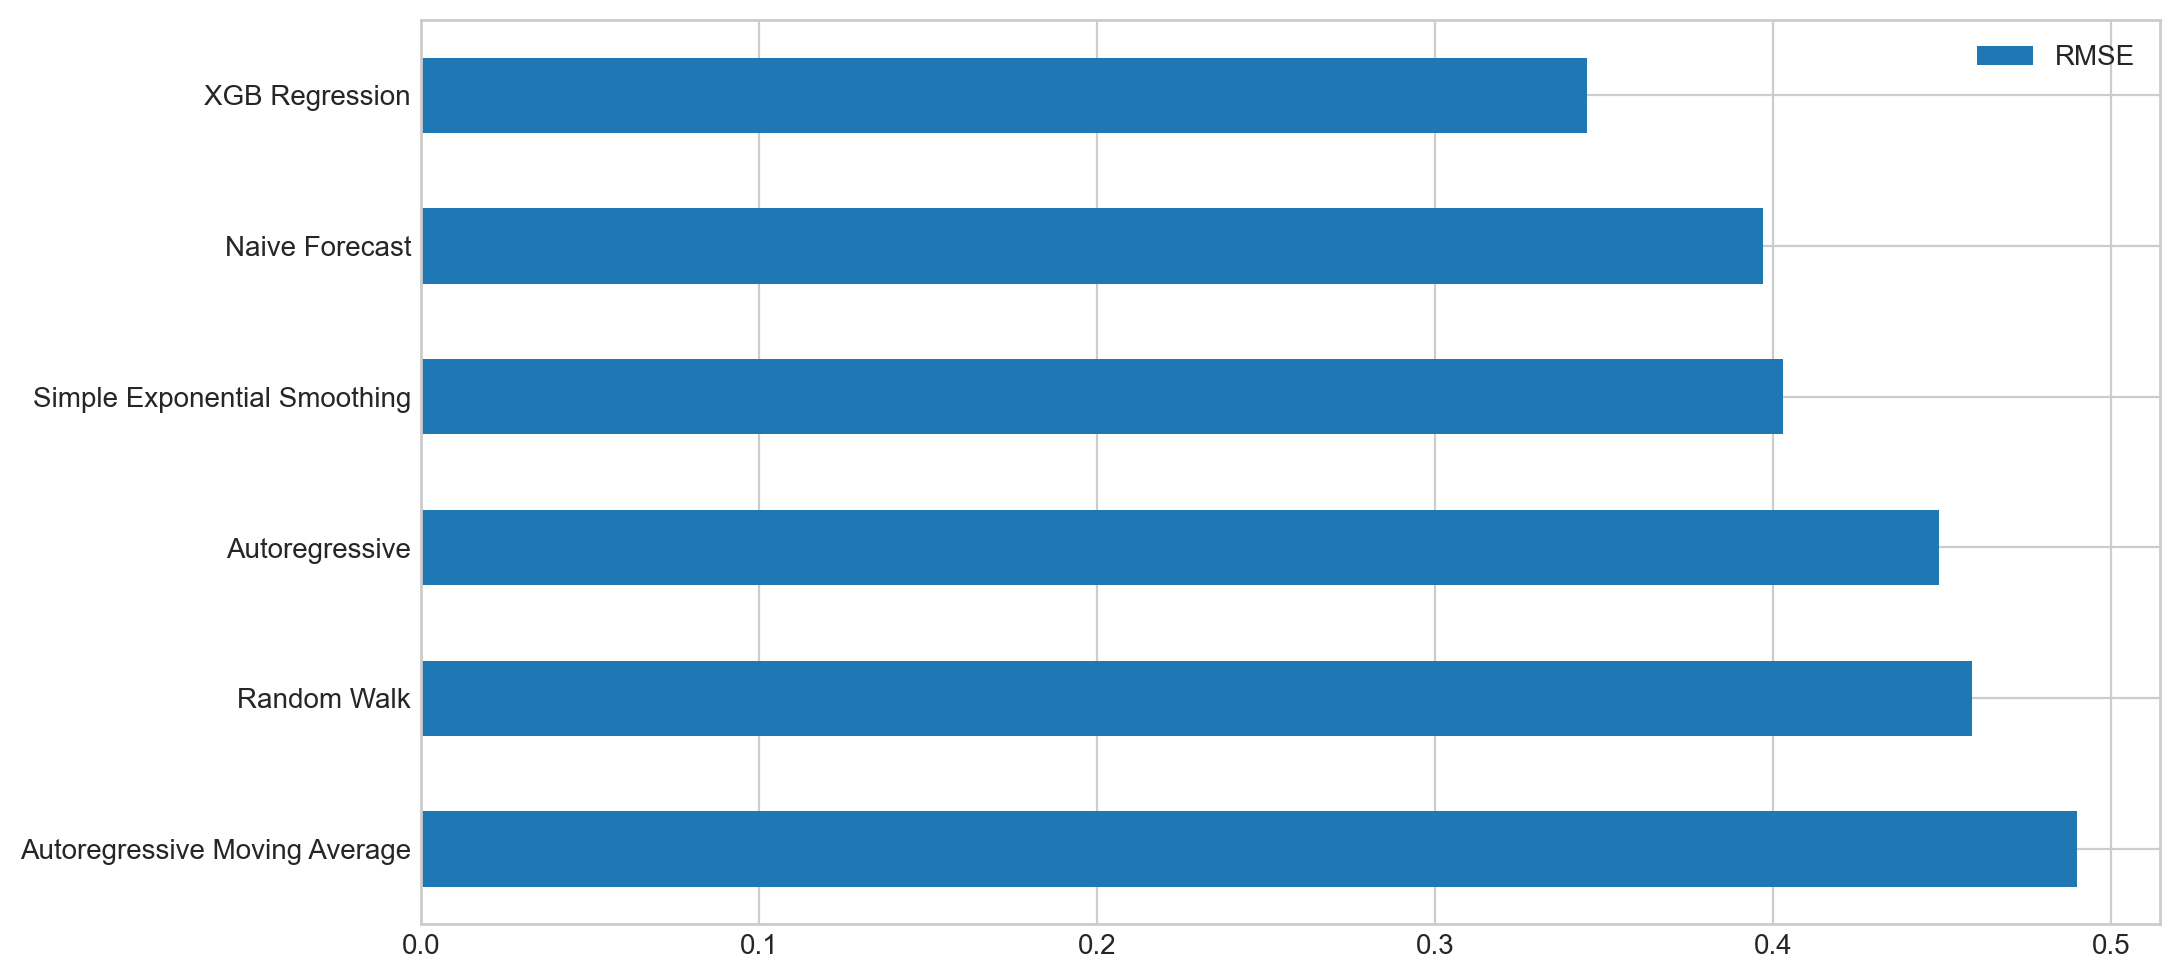

In [109]:
results.plot(kind='barh');

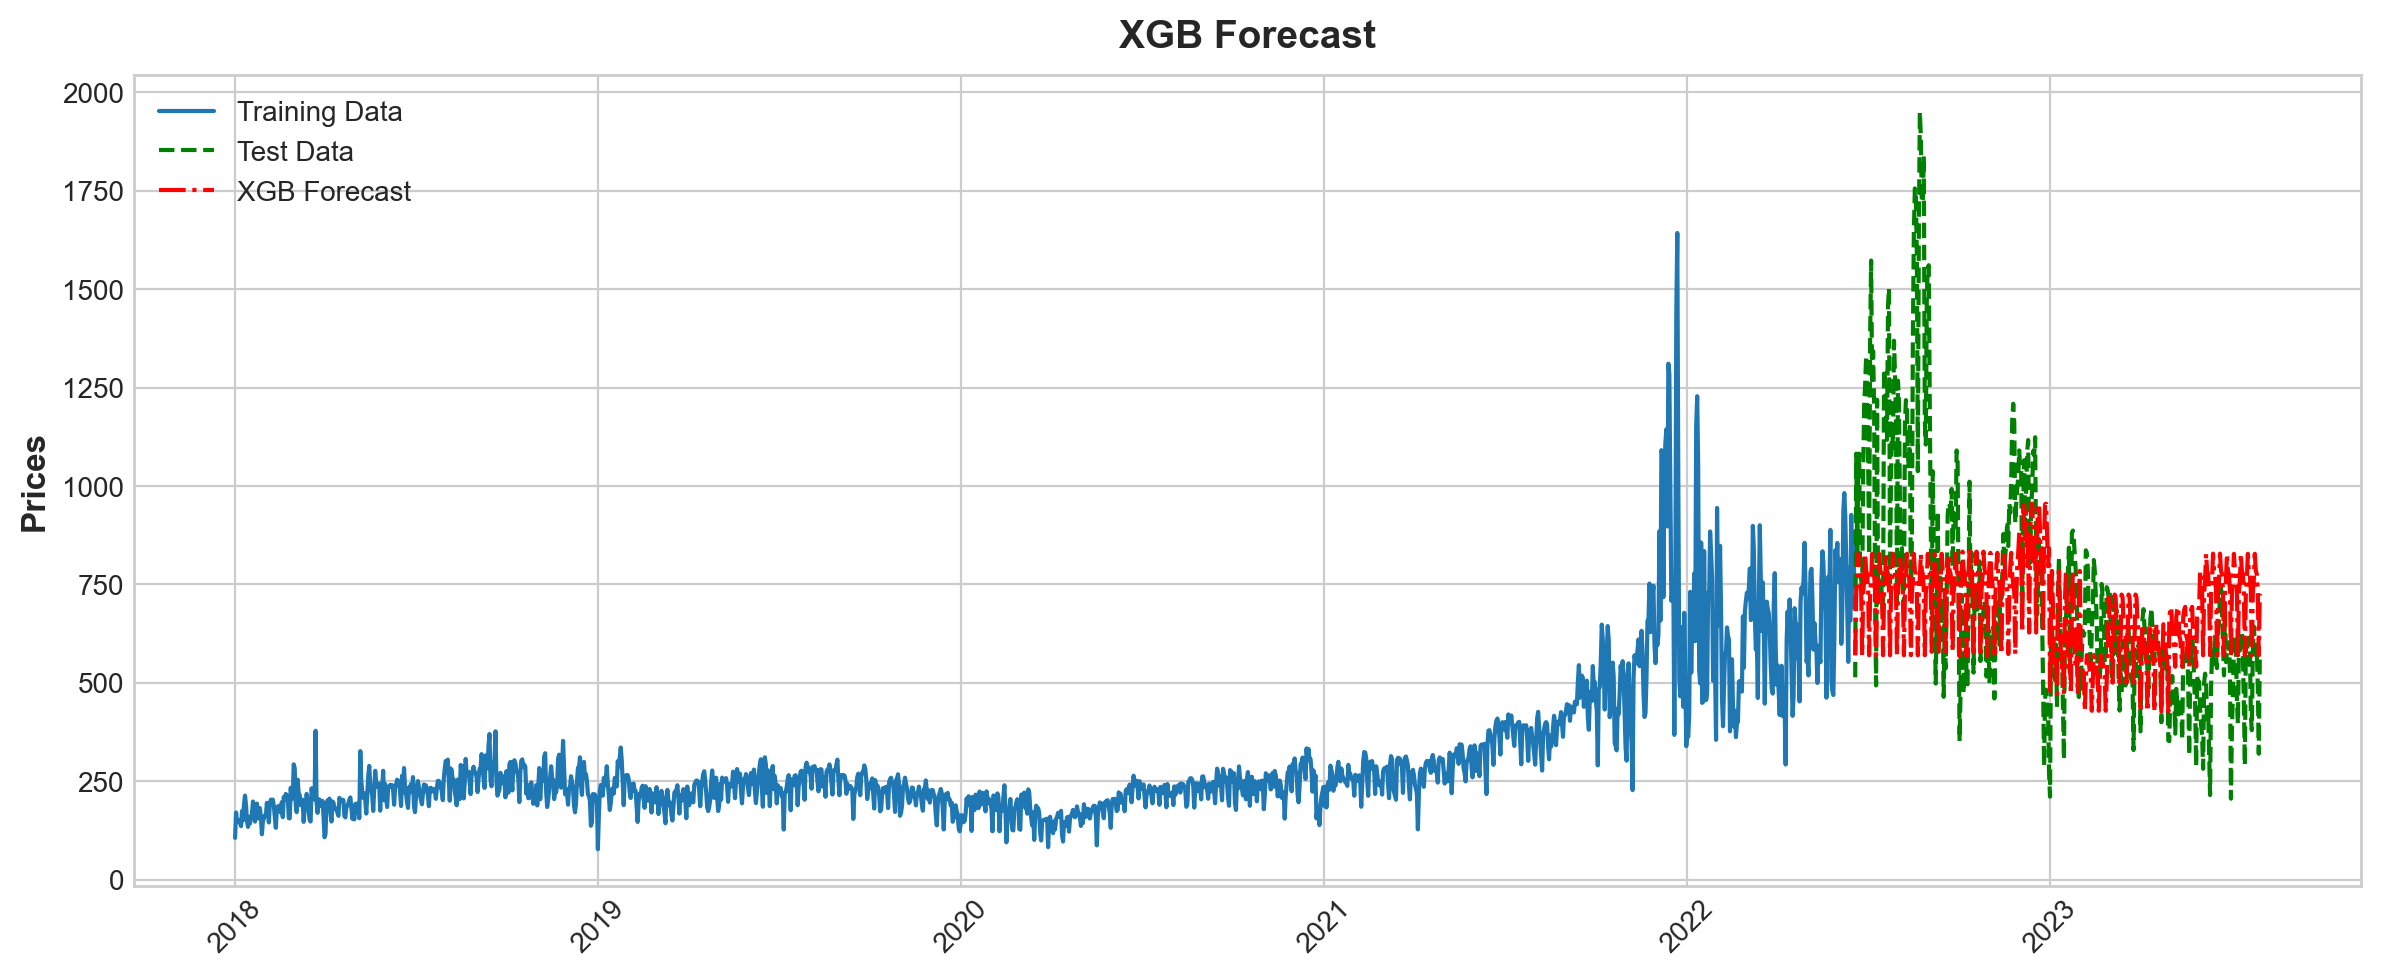

In [110]:
plt.figure(figsize=(12, 5))
plt.plot(train.index, np.exp(trainx['rce']), label='Training Data', linestyle='-')
plt.plot(test.index, np.exp(testx['rce']), label='Test Data', linestyle='--', color='green')
plt.plot(xgb.index, np.exp(xgb_forecast), label='XGB Forecast', linestyle='-.', color='red')
plt.ylabel('Prices')
plt.title('XGB Forecast')
plt.grid(True)
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout();

In [122]:
xgb_rmse_real = (mse(np.exp(y_true), np.exp(xgb_forecast), squared=False))

In [124]:
print(f'Real root mean squared error for the best performing model: {xgb_rmse_real:.2f}')

Real root mean squared error for the best performing model: 278.63


The best performing model is PLN 280 off of the actual prices.

As we can see, it's like predicting stock prices. Maybe in stable conditions, without the war going on it would have been easier to forecast.

It's very interesting to see, that one of two baseline models (naive forecast) performed only slightly worse than this advanced gradient boosting technique.